# Проект о стартапах
**Цель:** разработать модель для предсказания успешности стартапа (закроется или нет).
**План исследования:**
1. Загрузка и ознакомление с данными;
2. Предварительная обработка;
3. Полноценный разведочный анализ;
4. Разработка новых синтетических признаков;
5. Проверка на мультиколлинеарность;
6. Отбор финального набора обучающих признаков;
7. Выбор и обучение моделей;
8. Итоговая оценка качества предсказания лучшей модели;
9. Анализ важности ее признаков;
10. Подготовка отчета по исследованию.

# Описание данных
Представленные датасеты:   
`kaggle_startups_train_01.csv` - тренировочные данные  
`kaggle_startups_test_01.csv ` - тестовые данные   
`kaggle_startups_sample_submit_01.csv ` - пример предсказаний
* `name` - название стартапа
* `category_list` - список категорий, к которым относится стартап
* `funding_total_usd` - сбщая сумма финансирования в USD
* `status` - статус стартапа (закрыт или действующий) **целевой признак**
* `country_code` - Код страны
* `state_code` - Код штата
* `region` - Регион
* `city` - Город
* `funding_rounds` - Количество раундов финансирования
* `founded_at` - Дата основания
* `first_funding_at` - Дата первого раунда финансирования
* `last_funding_at` - Дата последнего раунда финансирования
* `closed_at` - Дата закрытия стартапа (если применимо)
* `lifetime` - Время существования стартапа в днях

# Шаг 1. Загрузка и ознакомление с данными.

Определим константы.

In [1]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

Загрузка библиотек.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik
import shap
import sklearn
import imblearn

from phik.report import plot_correlation_matrix
from phik import phik_matrix
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder, FunctionTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score,  make_scorer, precision_recall_curve, auc
from sklearn.inspection import permutation_importance 

In [3]:
submit = pd.read_csv('/kaggle/input/kaggle-startups-sample-submit/kaggle_startups_sample_submit_28062024.csv')
s_test =  pd.read_csv('/kaggle/input/kaggle-startups-test/kaggle_startups_test_28062024.csv')
s_train = pd.read_csv('/kaggle/input/kaggle-startups-train/kaggle_startups_train_28062024.csv')

pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', None)

display(submit.head(5))
display(s_test.head(5))
display(s_train.head(5))

,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,closed
4,DNA13,operating


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,"2,819,200.000",NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,"428,257.000",LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,"34,700,000.000",USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,"4,530,000.000",CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,"828,626.000",operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,"42,935,019.000",operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,"35,456,381.000",operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,"22,250,000.000",operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [4]:
submit.info()
s_test.info()
s_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime        

## Промежуточный вывод
**Цель:** загрузить данные и ознакомиться с общей информацией датасетов.  
**Результаты:**
1) Установлен объем данных: 
- `submit` 2 столбца, 13125 строк.
- `s_test` 11 столбцов, 13125 строк.
- `s_train` 13 столбцов, 52516 строк.

2) Проблем с разделением данных не обнаружено, по информации о датасетах видно, что в `s_train` и `s_test` имеются пропуски, типы данных не везде корректные.
3) Тренировочная и тестовая выборки имеют разные столбцы.

# Шаг 2. Предварительная обработка.

In [5]:
print(submit.dtypes)
print(s_test.dtypes)
print(s_train.dtypes)

name      object
status    object
dtype: object
name                  object
category_list         object
funding_total_usd    float64
country_code          object
state_code            object
region                object
city                  object
funding_rounds         int64
first_funding_at      object
last_funding_at       object
lifetime               int64
dtype: object
name                  object
category_list         object
funding_total_usd    float64
status                object
country_code          object
state_code            object
region                object
city                  object
funding_rounds         int64
founded_at            object
first_funding_at      object
last_funding_at       object
closed_at             object
dtype: object


Изменим тип данных столбцов `founded_at`, `first_funding_at`, `last_funding_at`, `closed_at` на datetime.

In [6]:
s_test['first_funding_at'] = pd.to_datetime(s_test['first_funding_at'], format = '%Y-%m-%d')
s_test['last_funding_at'] = pd.to_datetime(s_test['last_funding_at'], format = '%Y-%m-%d')
s_train['founded_at'] = pd.to_datetime(s_train['founded_at'], format = '%Y-%m-%d')
s_train['first_funding_at'] = pd.to_datetime(s_train['first_funding_at'], format = '%Y-%m-%d')
s_train['last_funding_at'] = pd.to_datetime(s_train['last_funding_at'], format = '%Y-%m-%d')
s_train['closed_at'] = pd.to_datetime(s_train['closed_at'], format = '%Y-%m-%d')

print(submit.dtypes)
print(s_test.dtypes)
print(s_train.dtypes)

name      object
status    object
dtype: object
name                         object
category_list                object
funding_total_usd           float64
country_code                 object
state_code                   object
region                       object
city                         object
funding_rounds                int64
first_funding_at     datetime64[ns]
last_funding_at      datetime64[ns]
lifetime                      int64
dtype: object
name                         object
category_list                object
funding_total_usd           float64
status                       object
country_code                 object
state_code                   object
region                       object
city                         object
funding_rounds                int64
founded_at           datetime64[ns]
first_funding_at     datetime64[ns]
last_funding_at      datetime64[ns]
closed_at            datetime64[ns]
dtype: object


Тип успешно изменен.

In [7]:
print(f'Количество выявленных явных дубликатов тестовой выборки: {s_test.duplicated().sum()}')
print(f'Количество выявленных явных дубликатов тренировочной выборки: {s_train.duplicated().sum()}')

Количество выявленных явных дубликатов тестовой выборки: 0
Количество выявленных явных дубликатов тренировочной выборки: 0


In [8]:
print(submit['name'].nunique())
print(s_test['name'].nunique())
print(s_train['name'].nunique())

13125
13125
52515


В столбцах `name` количество уникальных значений совпадает с длинной датасетов, следовательно дубликаты не обнаружены. Проверим на дубликаты без учета столбца `name`.

In [9]:
s_train = s_train[~s_train.duplicated(subset=s_train.columns.difference(['name']))]
s_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52506 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52505 non-null  object        
 1   category_list      50049 non-null  object        
 2   funding_total_usd  42445 non-null  float64       
 3   status             52506 non-null  object        
 4   country_code       47010 non-null  object        
 5   state_code         45749 non-null  object        
 6   region             46153 non-null  object        
 7   city               46153 non-null  object        
 8   funding_rounds     52506 non-null  int64         
 9   founded_at         52506 non-null  datetime64[ns]
 10  first_funding_at   52506 non-null  datetime64[ns]
 11  last_funding_at    52506 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory usage

Удалено 10 дубликатов.

In [10]:
def check (column):
    """
    Функция выводит:
    - Уникальные значения в столбце
    - Количество уникальных значений
    - Количество пропущенных значений (NaN)
    
    Для train и test.
    """
    print(" Данные для Train:")
    print(f"Уникальные значения: {s_train[column].unique()}")
    print(f"Количество уникальных значений: {s_train[column].nunique()}")
    print(f"Количество пропущенных значений: {s_train[column].isna().sum()}")
    print("-" * 40)
    
    print("Данные для Test:")
    print(f"Уникальные значения: {s_test[column].unique()}")
    print(f"Количество уникальных значений: {s_test[column].nunique()}")
    print(f"Количество пропущенных значений: {s_test[column].isna().sum()}")
    print("-" * 40)
    
check('country_code')

 Данные для Train:
Уникальные значения: ['CHE' 'USA' nan 'GBR' 'RUS' 'ESP' 'FRA' 'SWE' 'IND' 'KOR' 'AUS' 'TWN'
 'CHN' 'HUN' 'CAN' 'FIN' 'BRA' 'EGY' 'PRT' 'ISR' 'CHL' 'SVK' 'NLD' 'ARG'
 'ARE' 'JPN' 'IRL' 'DEU' 'LBN' 'EST' 'IDN' 'BEL' 'MEX' 'DNK' 'ITA' 'GRC'
 'ROM' 'TUR' 'SGP' 'SAU' 'MYS' 'NGA' 'QAT' 'VNM' 'BGR' 'GHA' 'UGA' 'JOR'
 'AUT' 'PAK' 'NZL' 'HKG' 'ZAF' 'LVA' 'NOR' 'HRV' 'VEN' 'PER' 'LUX' 'SVN'
 'POL' 'PHL' 'NIC' 'CZE' 'ISL' 'PAN' 'URY' 'BGD' 'MCO' 'GTM' 'THA' 'TTO'
 'UKR' 'KEN' 'CRI' 'DZA' 'LTU' 'CYM' 'MUS' 'BLR' 'SLV' 'COL' 'MLT' 'PSE'
 'BLZ' 'CYP' 'MMR' 'MKD' 'KHM' 'GIB' 'SRB' 'DOM' 'BWA' 'BLM' 'PRY' 'BMU'
 'TAN' 'LIE' 'GRD' 'UZB' 'GEO' 'SEN' 'ALB' 'ECU' 'MOZ' 'LKA' 'LAO' 'TUN'
 'HND' 'ZWE' 'BAH' 'MDA' 'MAF' 'BHR' 'AZE' 'MAR' 'KWT' 'IRN' 'GGY' 'KNA'
 'PRI' 'OMN' 'KAZ' 'JAM' 'NPL' 'ARM' 'TGO' 'RWA' 'BRN' 'JEY' 'SOM' 'CMR'
 'MNE' 'SYC' 'ZMB']
Количество уникальных значений: 134
Количество пропущенных значений: 5496
----------------------------------------
Данные для Test:
Уникаль

In [11]:
check('state_code')

 Данные для Train:
Уникальные значения: ['25' 'CA' nan 'VA' 'NJ' 'TX' 'OR' 'FL' 'WA' 'NY' 'C7' 'AZ' '91' 'GA' 'MA'
 'PA' 'MI' '56' 'MN' 'A8' 'DE' '26' 'Q5' '7' 'RI' '11' 'C5' 'CO' '3' '23'
 '1' 'ON' 'IL' 'OH' 'K2' '2' '14' '30' 'H9' 'AL' '29' '6' 'NC' '5' '12'
 '22' 'MD' '48' 'ND' '40' 'K4' 'VT' '16' '4' 'UT' 'IN' '8' '9' '18' 'CT'
 '13' 'NV' '10' 'B8' '27' '17' 'IA' 'WI' 'L9' 'NM' 'B7' 'MO' 'BC' '21'
 'F7' 'ME' 'NH' '35' 'NS' 'C1' 'C3' 'SC' '20' 'TN' 'A6' '51' 'I7' 'LA'
 'KS' '42' 'N7' 'U8' 'I2' 'AR' '19' 'NE' '41' 'QC' 'AB' '37' '15' '97'
 'V2' 'D2' 'DC' 'A7' 'C9' 'F8' 'Y2' 'B9' 'J7' 'M9' 'G2' 'H3' 'ID' 'NB'
 '28' 'V8' '34' 'B5' 'F2' 'A9' 'Z7' '53' 'H8' 'MT' 'MB' 'KY' '61' '60'
 'B4' 'H7' '82' 'A2' 'C8' 'L3' 'B3' 'D9' 'M3' 'MS' '31' '33' '52' 'HI'
 'AK' '78' '72' 'Q4' 'Y4' 'WY' '32' 'E6' 'Q3' 'F9' '24' 'OK' 'X4' '81'
 'A1' '86' 'P4' 'E7' 'P9' '73' 'W5' 'D4' 'E9' 'A4' 'I5' 'B2' 'R3' 'N5'
 '59' 'K7' 'H5' 'H2' 'N3' 'A5' 'T5' 'G5' 'E8' 'SD' '77' '65' '36' 'WV'
 '68' 'P3' 'X5' '66' 'D8' '

In [12]:
check('region')

 Данные для Train:
Уникальные значения: ['Zurich' 'SF Bay Area' nan ... 'Haywards Heath' 'Herzogenaurach'
 'Doncaster']
Количество уникальных значений: 1036
Количество пропущенных значений: 6353
----------------------------------------
Данные для Test:
Уникальные значения: [nan 'TN - Other' 'Esch-sur-alzette' 'San Diego' 'Ottawa'
 'Washington, D.C.' 'Allentown' 'Phoenix' 'Kuala Lumpur' 'Cologne'
 'Huntsville' 'Boston' 'New York City' 'SF Bay Area' 'Dusseldrof'
 'Anaheim' 'Berlin' 'London' 'Ontario - Inland Empire' 'Philadelphia'
 'Atlanta' 'Montreal' 'Nashville' 'Palm Beaches' 'Seattle' 'Cleveland'
 'Denver' 'Toronto' 'Paris' 'Meridian' 'Miami' 'Terni' 'Beijing'
 'Buenos Aires' 'Asheville' 'Los Angeles' 'Coventry' 'NLD - Other' 'Cork'
 'Sydney' 'CA - Other' 'Dallas' 'Sarasota - Bradenton' 'Zurich' 'Hangzhou'
 'NY - Other' 'Santiago' 'Bormujos' 'New Delhi' 'MO - Other' 'Tel Aviv'
 'Ft. Lauderdale' 'Leeds' 'Charlotte' 'Worcester' 'Austin' 'Bangalore'
 'Pittsburgh' 'Shanghai' 'Melbourne' 

В значениях регионов полная путаница, присутствуют значения типа `NoÃ¡in` или `UT - Other`. Не совсем понятно, как стоит их интерпретировать, оставляем пока без изменений.

In [13]:
check('city')

 Данные для Train:
Уникальные значения: ['Zürich' 'Redwood City' 'San Jose' ... 'Circleville' 'Doncaster'
 'Centreville']
Количество уникальных значений: 4477
Количество пропущенных значений: 6353
----------------------------------------
Данные для Test:
Уникальные значения: [nan 'Humboldt' 'Esch-sur-alzette' ... "Champagne-au-mont-d'or"
 "Be'er Sheva" 'Taichung']
Количество уникальных значений: 2117
Количество пропущенных значений: 1587
----------------------------------------


In [14]:
check('category_list')

 Данные для Train:
Уникальные значения: ['Online Reservations|Restaurants' 'Manufacturing|Medical|Medical Devices'
 'Biotechnology' ... 'Gambling|Games|Online Gaming|Sports'
 'Aerospace|Mobile|Transportation|Travel'
 'Online Rental|Parking|Price Comparison']
Количество уникальных значений: 22105
Количество пропущенных значений: 2457
----------------------------------------
Данные для Test:
Уникальные значения: ['Clean Technology' 'Hospitality' 'Finance' ...
 'Design|E-Commerce|Marketplaces|Printing'
 'Advertising Exchanges|Mobile|Mobile Advertising'
 'Communications Hardware|Messaging|Mobile|Office Space|Technology|VoIP']
Количество уникальных значений: 6206
Количество пропущенных значений: 591
----------------------------------------


Обилие категорий. Разделим категории и оставим первое два значение.

In [15]:
s_train['category_list'] = s_train['category_list'].str.split('|').str[0]
s_test['category_list'] = s_test['category_list'].str.split('|').str[0]

check('category_list')

 Данные для Train:
Уникальные значения: ['Online Reservations' 'Manufacturing' 'Biotechnology' 'Health Care'
 'Mobile' 'Analytics' 'Software' 'Semiconductors' 'Clean Technology' nan
 'Nanotechnology' 'Customer Service' 'Banking' 'Messaging' 'Consumers'
 'Generation Y-Z' 'College Recruiting' 'Technology' 'Finance'
 'Cloud Computing' 'DIY' 'Entertainment' 'Internet' 'Advertising'
 'Fitness' 'Consumer Goods' 'Moneymaking' 'Media' 'Apps' 'Enterprises'
 'Adventure Travel' 'Travel' 'Home Owners' 'E-Commerce' 'Collaboration'
 '3D' 'Medical' 'Big Data Analytics' 'Business Services'
 'Local Businesses' 'Sports' 'Curated Web' 'Cloud Security'
 'Advanced Materials' 'Fashion' 'E-Books' 'Real Estate'
 'Social Network Media' 'Enterprise Software' 'Architecture' 'Music'
 'Broadcasting' 'Eyewear' 'Event Management' 'Healthcare Services'
 'Health and Wellness' 'Automotive' 'Education' 'Direct Sales' 'Events'
 'Digital Media' 'Pharmaceuticals' 'Games' 'Energy' 'Hardware + Software'
 'Babies' 'Home Decor

Заполним пропуски в тренировочной выборке.

In [16]:
s_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52506 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52505 non-null  object        
 1   category_list      50049 non-null  object        
 2   funding_total_usd  42445 non-null  float64       
 3   status             52506 non-null  object        
 4   country_code       47010 non-null  object        
 5   state_code         45749 non-null  object        
 6   region             46153 non-null  object        
 7   city               46153 non-null  object        
 8   funding_rounds     52506 non-null  int64         
 9   founded_at         52506 non-null  datetime64[ns]
 10  first_funding_at   52506 non-null  datetime64[ns]
 11  last_funding_at    52506 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory usage

Удалим строки где нет информации о месте расположении и сумме финансирования стартапа. Пропуски в сумме финансирования заполним нулем, в дате закрытия укажем 1 января 2018 года, в неизвестных категориях укажем unknown.

In [17]:
s_train = s_train.dropna(subset=['country_code', 'state_code', 'region', 'city','funding_total_usd'], how='all')
s_train['funding_total_usd'] = s_train['funding_total_usd'].fillna(0)
s_train['category_list'] = s_train['category_list'].fillna('Unknown')
s_train['closed_at'] = s_train['closed_at'].fillna('2018-01-01')
s_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50686 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               50685 non-null  object        
 1   category_list      50686 non-null  object        
 2   funding_total_usd  50686 non-null  float64       
 3   status             50686 non-null  object        
 4   country_code       47010 non-null  object        
 5   state_code         45749 non-null  object        
 6   region             46153 non-null  object        
 7   city               46153 non-null  object        
 8   funding_rounds     50686 non-null  int64         
 9   founded_at         50686 non-null  datetime64[ns]
 10  first_funding_at   50686 non-null  datetime64[ns]
 11  last_funding_at    50686 non-null  datetime64[ns]
 12  closed_at          50686 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory usage

## Промежуточный вывод
**Цель:** выполнить предобработку данных.  
**Задачи:**
1. Проверка типов данных.
2. Выявление и обработка явных и неявных дубликатов.
3. Выявление пропусков.

**Результаты**

1) Проверка и исправление типов данных:
- Исправлен тип на `datetime` в столбцах с датами.

2) Выявление и обработка явных и неявных дубликатов:
- Явные дубликаты невыявлены.
- Неявные дубликаты невыявлены.
- Урежено количество уникальных значений столбца `category_list`.

3) Выявление пропусков:
- Выявлены и обработаны пропуски в `s_train`, удалены строки с неизвестными значениями в `country_code`.

# Шаг 3. Полноценный разведочный анализ.

Создадим две функции для визуализации значений по таргету.

### 3.1. Анализ категориальных признаков

In [18]:
def categorical_features(df, attribute, title, hue='status', top_n=100):
    """
    Визуализация категориальных признаков с возможностью сегментации по целевому признаку.

    Параметры:
        df: Датафрейм с данными
        attribute: Название столбца с категориальным признаком
        title: Заголовок графиков
        hue: Название столбца с целевым признаком (по умолчанию 'status')
        top_n: Максимальное количество категорий для отображения (по умолчанию 100)

    Возвращает:
        Графики
    """
    counts = df[attribute].value_counts(ascending=False)
    if len(counts) > top_n:
        counts = counts[:top_n]

    if hue not in df.columns:
        hue = None

    if hue:
        fig, axes = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 3]})
        show_percentage = True
    else:
        fig, axes = plt.subplots(1, 1, figsize=(12, 6))
        axes = [axes]
        show_percentage = False

    sns.countplot(
        x=attribute, data=df[df[attribute].isin(counts.index)], palette='afmhot_r', hue=hue,
        order=counts.index, ax=axes[0]
    )
    axes[0].set_title(title, fontsize=14, fontweight='bold')
    axes[0].set_xlabel(attribute, fontsize=10)
    axes[0].set_ylabel('Частота', fontsize=10)
    axes[0].tick_params(axis='x', rotation=90)
    if hue:
        axes[0].legend(title=hue, loc='upper right')

    if show_percentage:
        percentage = df[df[attribute].isin(counts.index)].groupby([attribute, hue]).size().unstack().fillna(0)
        percentage = percentage.div(percentage.sum(axis=1), axis=0)  
        percentage = percentage.loc[counts.index]

        percentage.plot(kind='bar', stacked=True, colormap='Set2', ax=axes[1])
        axes[1].set_ylabel('Доля', fontsize=12)
        axes[1].set_xlabel(attribute, fontsize=12)
        axes[1].tick_params(axis='x', rotation=90)
        axes[1].legend(title=hue, bbox_to_anchor=(1, 1), loc='upper left')
        axes[1].set_title(f"{title} (долевое распределение)", fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    print(counts)

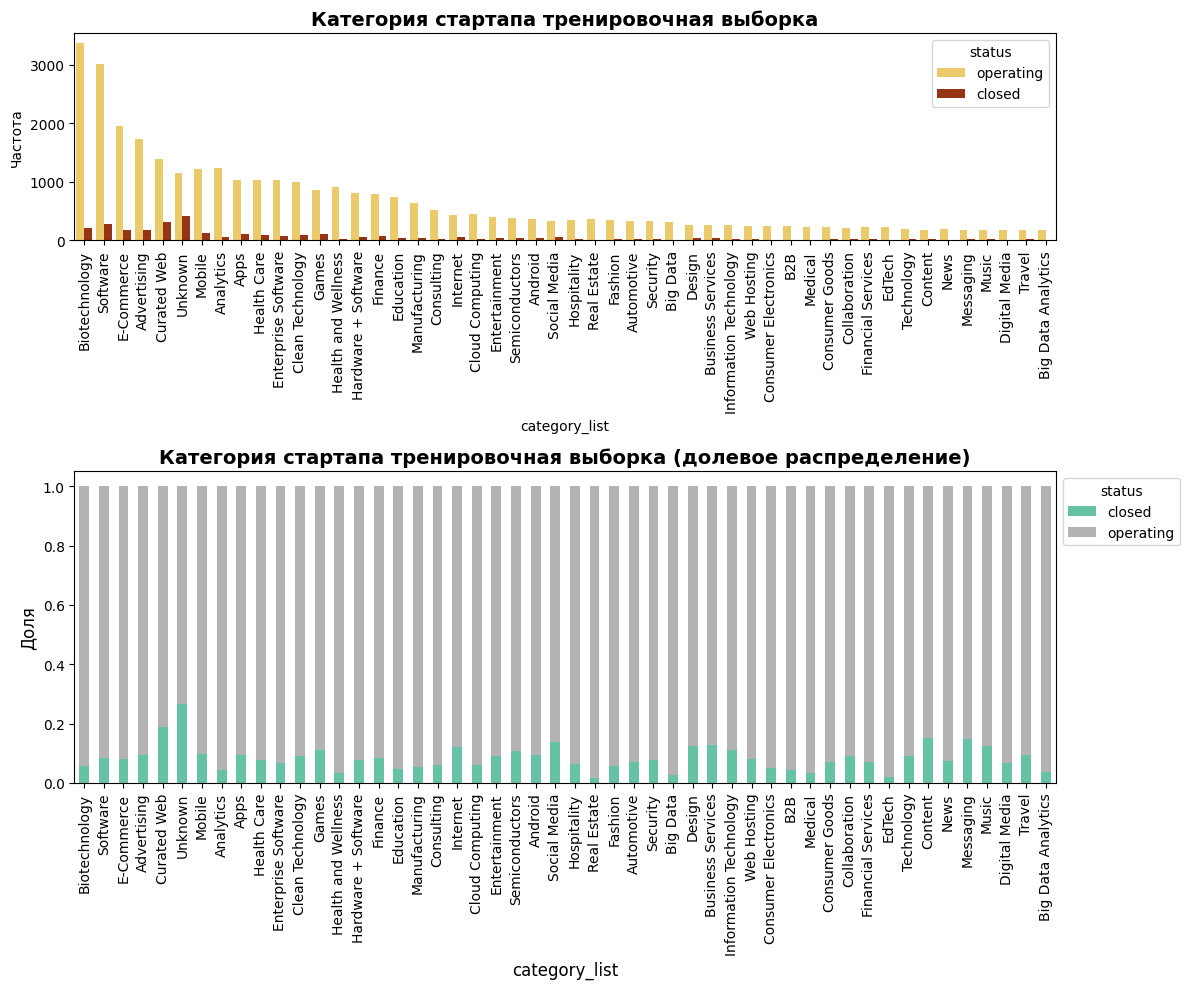

category_list
Biotechnology             3577
Software                  3283
E-Commerce                2122
Advertising               1901
Curated Web               1700
Unknown                   1579
Mobile                    1357
Analytics                 1300
Apps                      1147
Health Care               1120
Enterprise Software       1101
Clean Technology          1099
Games                      979
Health and Wellness        946
Hardware + Software        869
Finance                    857
Education                  785
Manufacturing              672
Consulting                 555
Internet                   491
Cloud Computing            487
Entertainment              435
Semiconductors             425
Android                    396
Social Media               389
Hospitality                376
Real Estate                374
Fashion                    361
Automotive                 359
Security                   356
Big Data                   331
Design                   

In [19]:
categorical_features(s_train, 'category_list', 'Категория стартапа тренировочная выборка','status', 50)

Из определенных категорий наиболее многочисленные - биотехнологии, програмные обеспечения, электронная коммерция. Наибольшее число закрытых компаний в сфере веб-разработки.

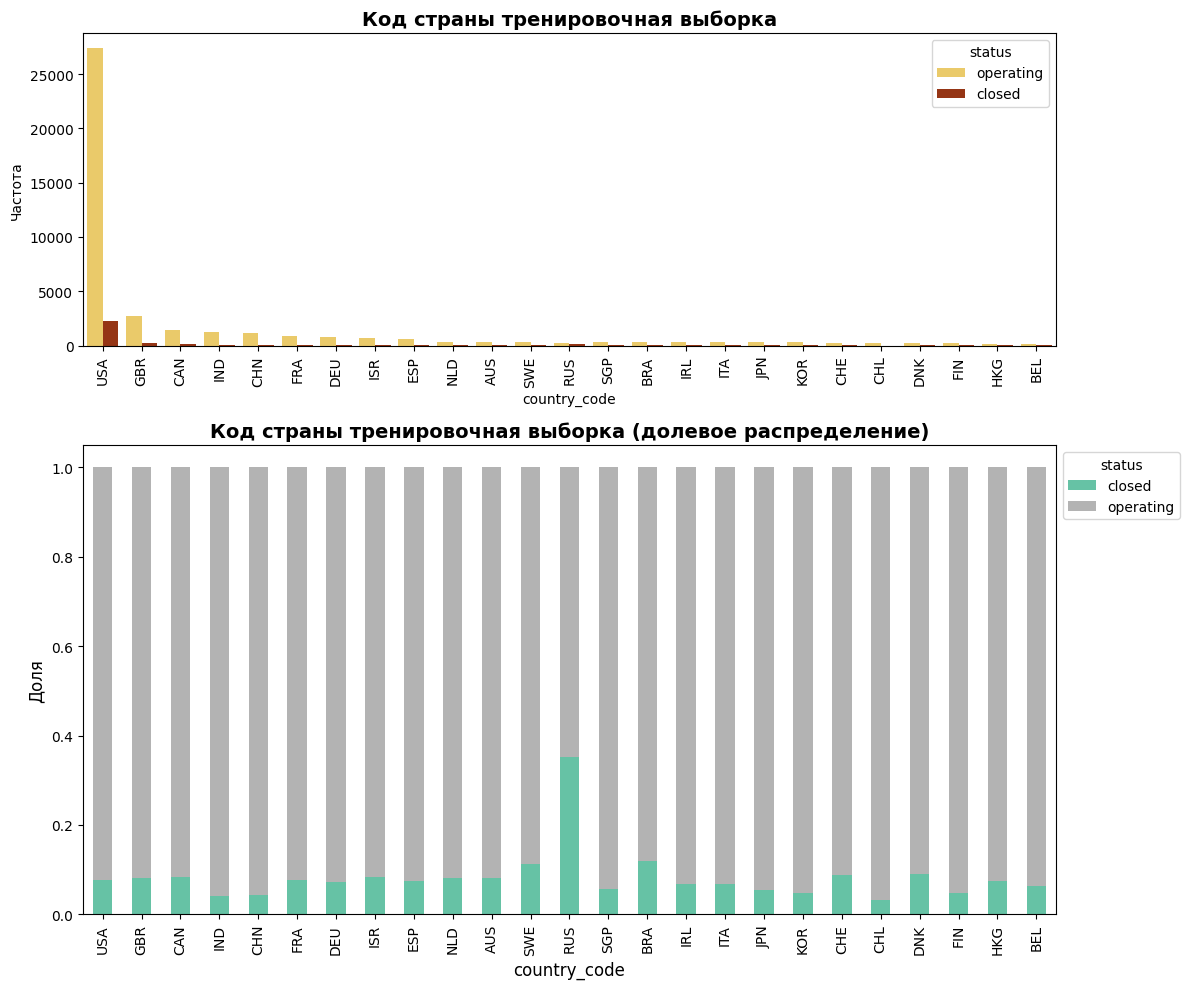

country_code
USA    29700
GBR     2925
CAN     1540
IND     1276
CHN     1240
FRA      916
DEU      834
ISR      767
ESP      607
NLD      380
AUS      379
SWE      373
RUS      369
SGP      356
BRA      355
IRL      351
ITA      321
JPN      314
KOR      299
CHE      262
CHL      252
DNK      242
FIN      227
HKG      162
BEL      158
Name: count, dtype: int64


In [20]:
categorical_features(s_train, 'country_code', 'Код страны тренировочная выборка','status', 25)

Наибольшее количество стартапов создано в Сша, Великобритании и Канаде. Наибольшая доля закрытых компаний в России (более 30%), Бразилии и Швеции (около 10%).

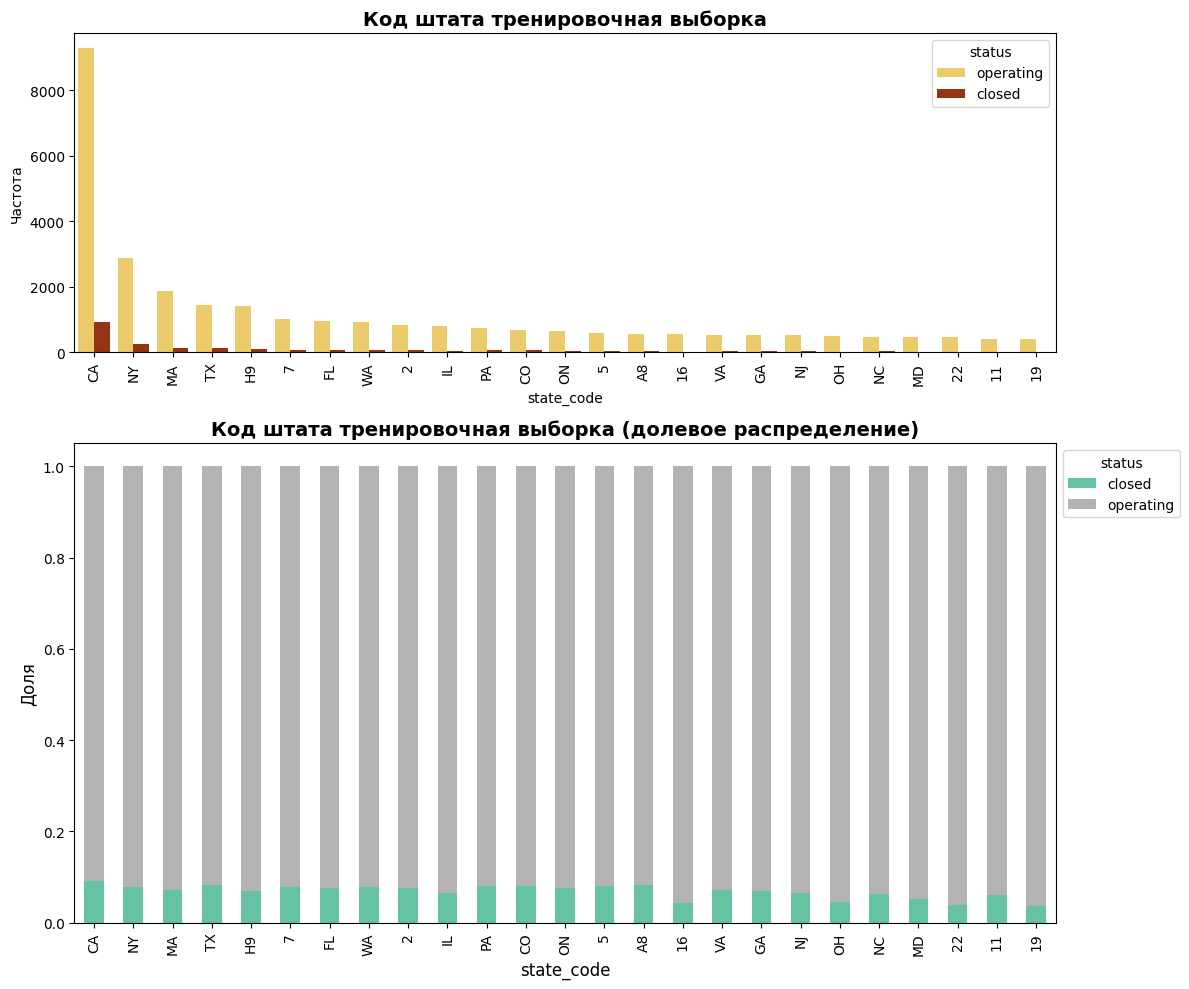

state_code
CA    10218
NY     3112
MA     2020
TX     1562
H9     1510
7      1094
FL     1038
WA      997
2       913
IL      859
PA      795
CO      735
ON      721
5       630
A8      601
16      590
VA      581
GA      570
NJ      560
OH      520
NC      501
MD      492
22      491
11      423
19      413
Name: count, dtype: int64


In [21]:
categorical_features(s_train, 'state_code', 'Код штата тренировочная выборка','status', 25)

Ожидаемо, самый продуктивный штат США на стартапы - Калифорния, на втором месте Нью-Йорк, на третьем - Массачусетс. Наибольшее количество закрывшихся организаций в Калифорнии(около 10%), Колорадо, Флорида, Вашингтон.

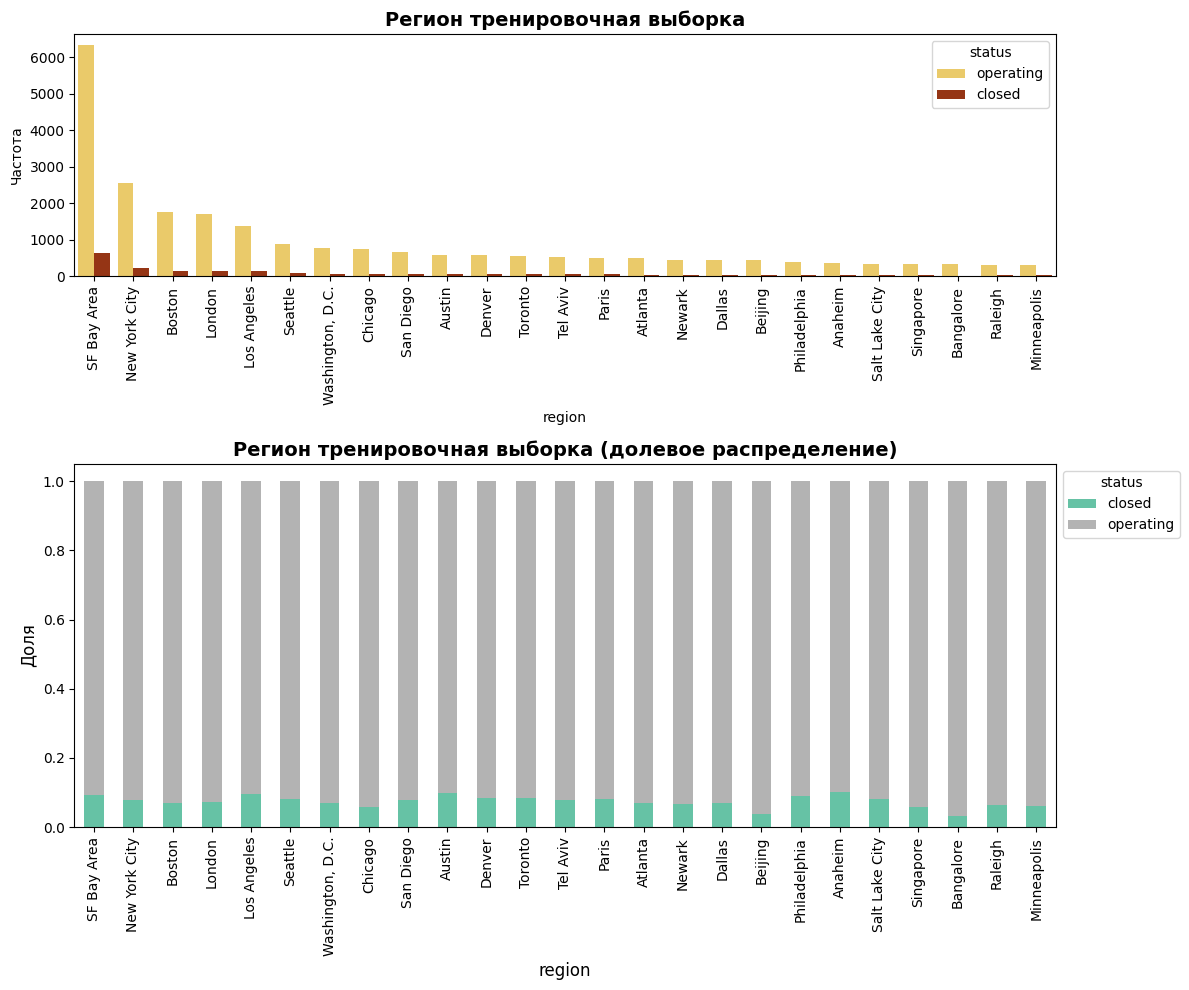

region
SF Bay Area         6969
New York City       2776
Boston              1890
London              1840
Los Angeles         1513
Seattle              955
Washington, D.C.     817
Chicago              778
San Diego            703
Austin               652
Denver               638
Toronto              591
Tel Aviv             571
Paris                546
Atlanta              538
Newark               472
Dallas               468
Beijing              464
Philadelphia         434
Anaheim              405
Salt Lake City       350
Singapore            343
Bangalore            340
Raleigh              326
Minneapolis          319
Name: count, dtype: int64


In [22]:
categorical_features(s_train, 'region', 'Регион тренировочная выборка','status', 25)

Наибльшее количество организаций из Области залива Сан-Франциско, Нью-Йорка, Бостона и Лондона. Наибольшее количество закрывшихся компаний в Анахайме(Калифорния), Остине(Техас), Лос-Анжелесе и Области залива Сан-Франциско.

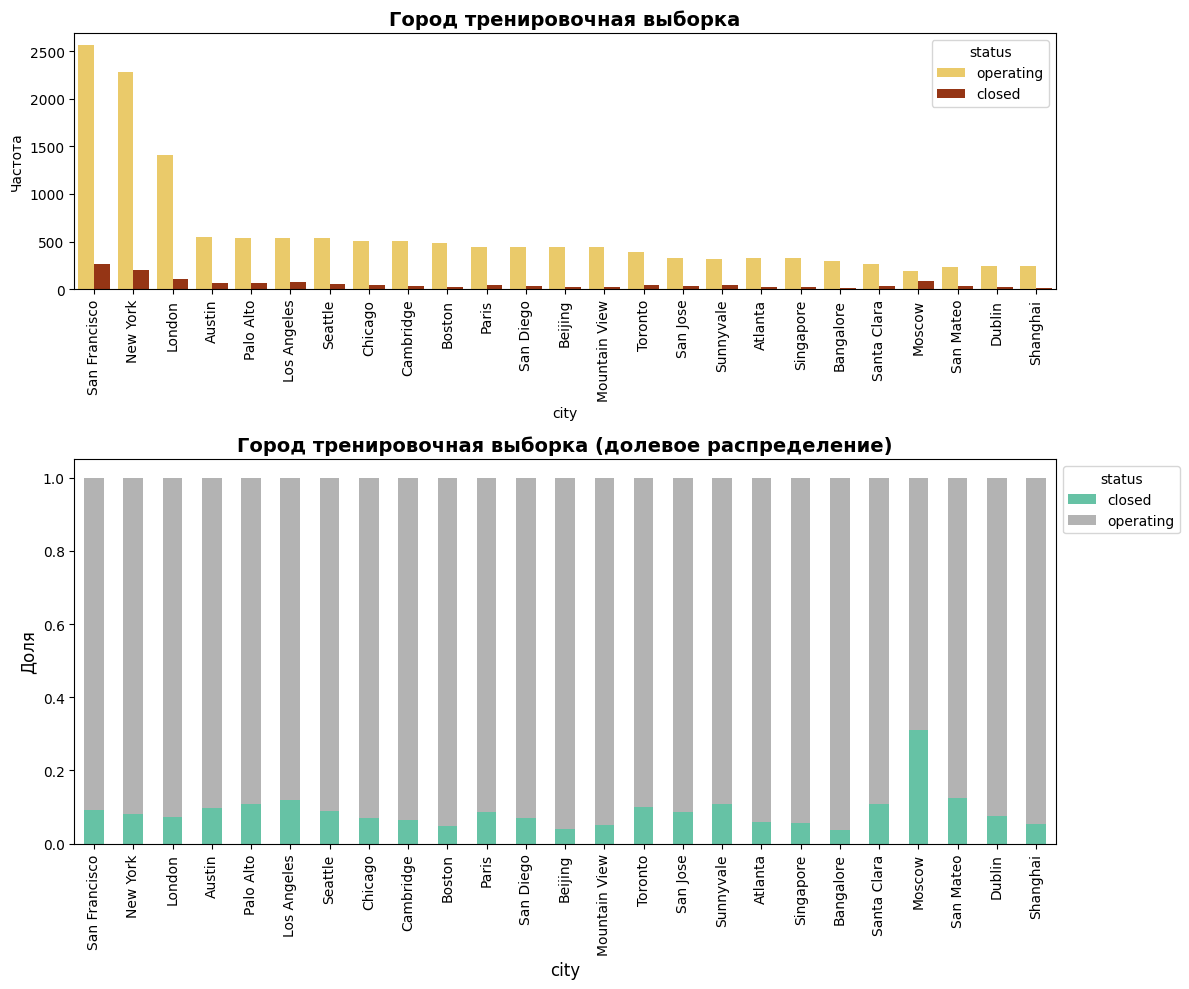

city
San Francisco    2824
New York         2486
London           1514
Austin            609
Palo Alto         606
Los Angeles       604
Seattle           592
Chicago           546
Cambridge         542
Boston            508
Paris             485
San Diego         480
Beijing           464
Mountain View     463
Toronto           429
San Jose          359
Sunnyvale         358
Atlanta           346
Singapore         341
Bangalore         307
Santa Clara       299
Moscow            268
San Mateo         266
Dublin            263
Shanghai          259
Name: count, dtype: int64


In [23]:
categorical_features(s_train, 'city', 'Город тренировочная выборка','status', 25)

Наибольшее количество организаций из городов Сан Франциско, Нью-Йорк, Лондон. Наибольшее количество закрывшихся стартапов в Москве(более 30%), Сан Матео (Калифорния), Лос Анжелесе.

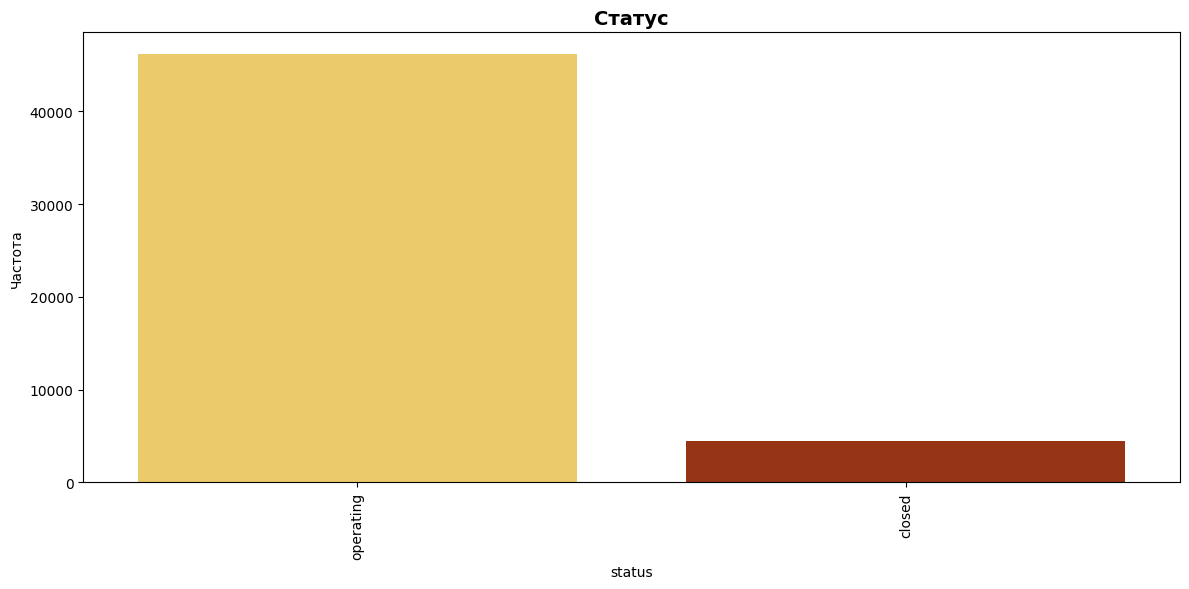

status
operating    46199
closed        4487
Name: count, dtype: int64


In [24]:
categorical_features(s_train, 'status', 'Статус', 25)

Явный дисбаланс классов, который в будущем нужно будет учесть.

*Исследование категориальных признаков тестовой выборки*

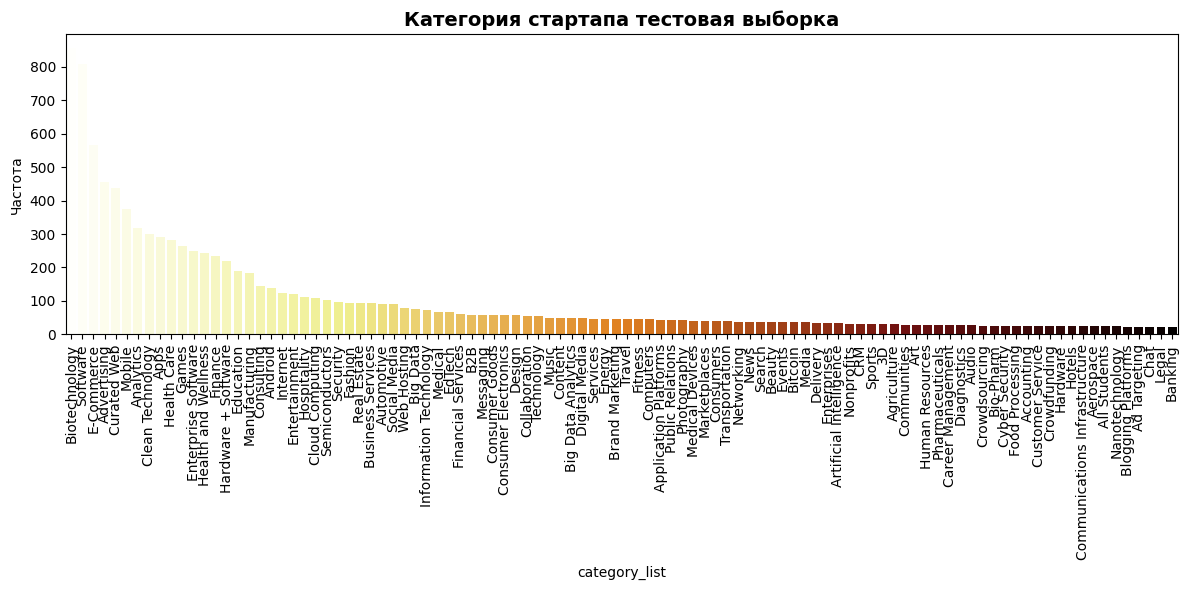

category_list
Biotechnology         855
Software              809
E-Commerce            566
Advertising           456
Curated Web           436
                     ... 
Blogging Platforms     23
Ad Targeting           23
Chat                   23
Legal                  22
Banking                22
Name: count, Length: 100, dtype: int64


In [25]:
categorical_features(s_test, 'category_list', 'Категория стартапа тестовая выборка', 50)

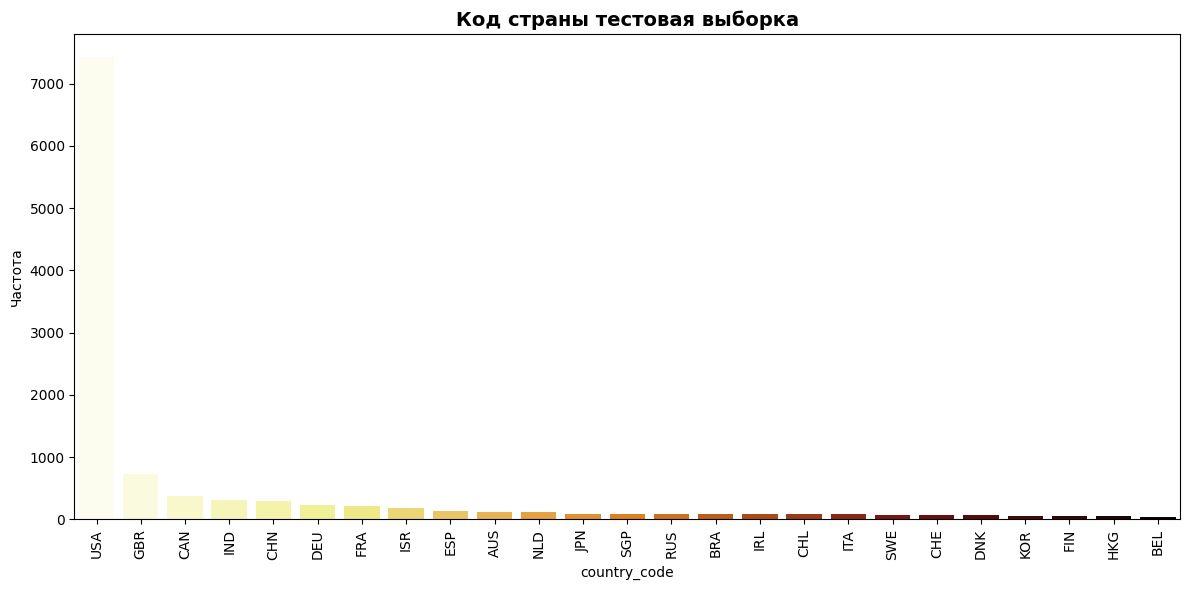

country_code
USA    7428
GBR     725
CAN     369
IND     307
CHN     301
DEU     237
FRA     213
ISR     190
ESP     134
AUS     120
NLD     112
JPN      93
SGP      91
RUS      87
BRA      85
IRL      83
CHL      80
ITA      79
SWE      75
CHE      69
DNK      68
KOR      61
FIN      52
HKG      47
BEL      45
Name: count, dtype: int64


In [26]:
categorical_features(s_test, 'country_code', 'Код страны тестовая выборка','status', 25)

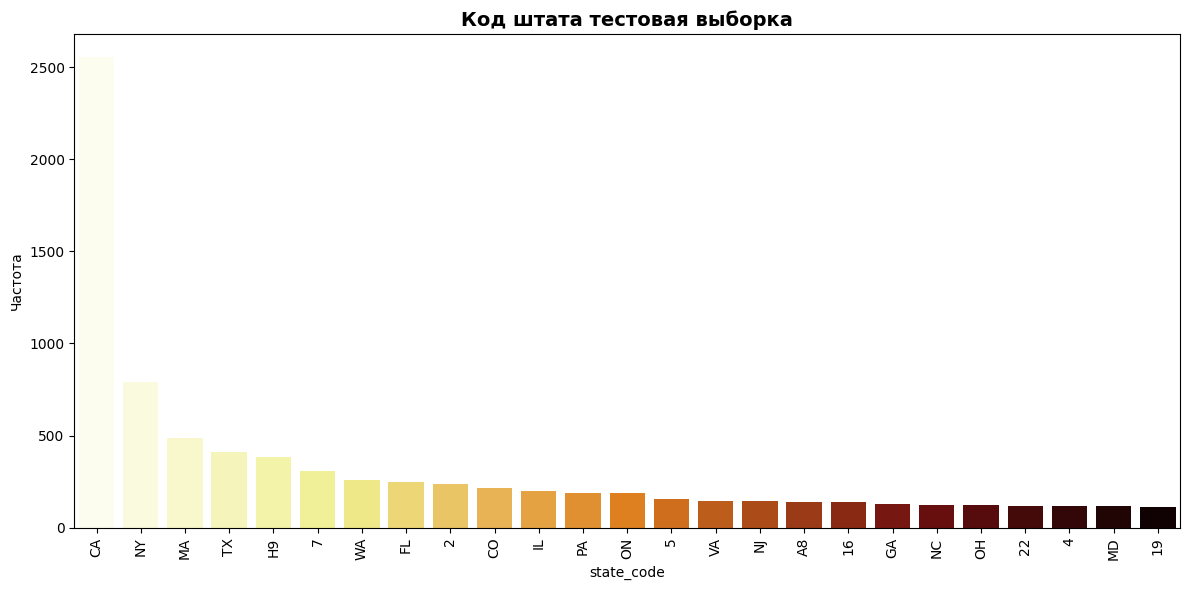

state_code
CA    2552
NY     789
MA     487
TX     410
H9     382
7      306
WA     258
FL     249
2      237
CO     216
IL     201
PA     191
ON     187
5      154
VA     146
NJ     145
A8     142
16     140
GA     129
NC     125
OH     124
22     120
4      119
MD     116
19     112
Name: count, dtype: int64


In [27]:
categorical_features(s_test, 'state_code', 'Код штата тестовая выборка','status', 25)

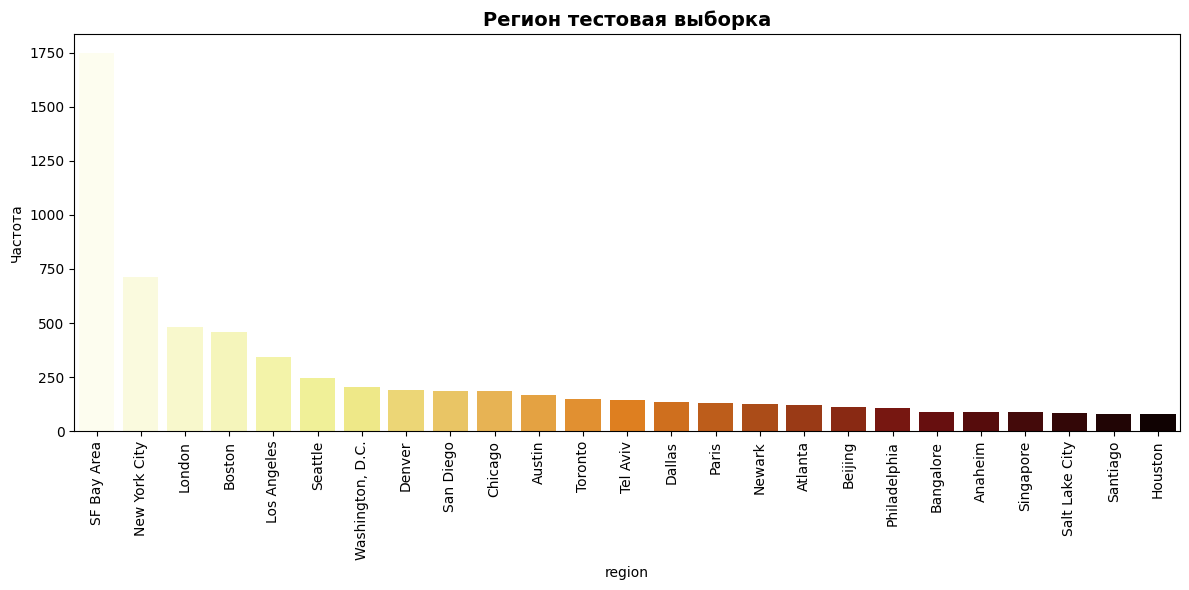

region
SF Bay Area         1750
New York City        712
London               481
Boston               460
Los Angeles          343
Seattle              247
Washington, D.C.     203
Denver               190
San Diego            186
Chicago              184
Austin               167
Toronto              149
Tel Aviv             143
Dallas               134
Paris                132
Newark               125
Atlanta              120
Beijing              112
Philadelphia         107
Bangalore             90
Anaheim               89
Singapore             87
Salt Lake City        86
Santiago              79
Houston               77
Name: count, dtype: int64


In [28]:
categorical_features(s_test, 'region', 'Регион тестовая выборка','status', 25)

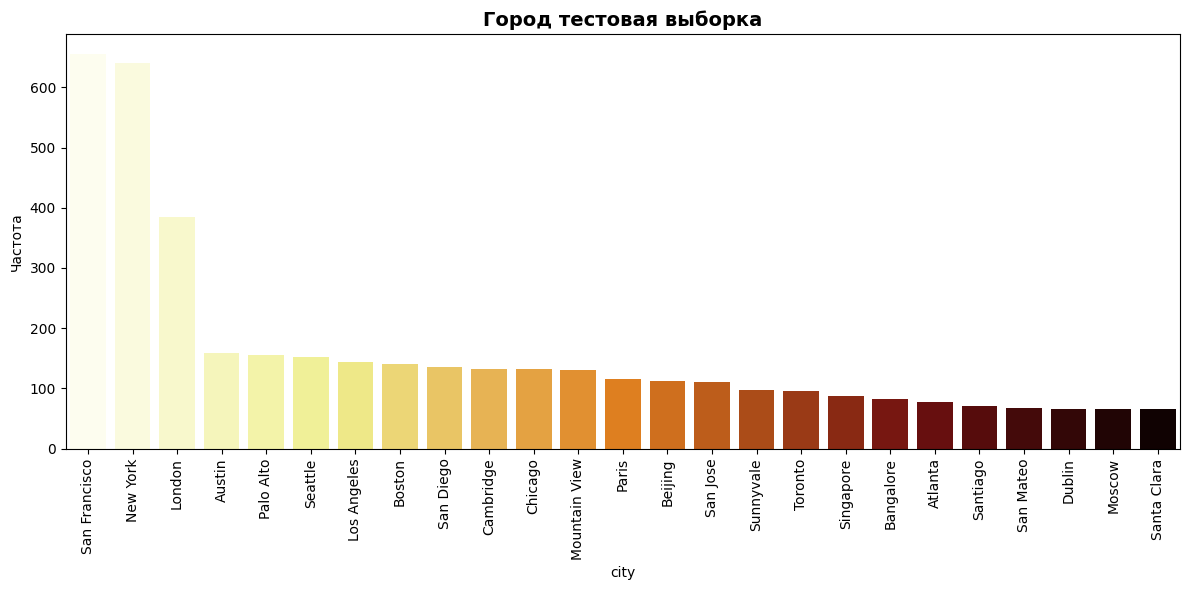

city
San Francisco    656
New York         641
London           384
Austin           159
Palo Alto        155
Seattle          152
Los Angeles      144
Boston           140
San Diego        136
Cambridge        133
Chicago          132
Mountain View    130
Paris            116
Beijing          112
San Jose         111
Sunnyvale         97
Toronto           95
Singapore         87
Bangalore         82
Atlanta           77
Santiago          71
San Mateo         68
Dublin            66
Moscow            66
Santa Clara       66
Name: count, dtype: int64


In [29]:
categorical_features(s_test, 'city', 'Город тестовая выборка','status', 25)

Распределение категориальных признаков тестовой выборки схоже с распределением категориальной выборки.

###  3.2. Анализ количественных признаков

In [30]:
def quantitative_features(df, attribute, title, hue=None, bins=20, remove_outliers=False):
    """
    Визуализация количественных признаков: гистограмма и ящик с усами.

    Параметры:
        df: DataFrame
        attribute: Название столбца с числовым признаком
        title: Заголовок графиков
        hue: Категориальный признак для сегментации
        bins: Количество бинов в гистограмме

    Возвращает:
        Графики
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    if remove_outliers:
        q1 = df[attribute].quantile(0.05)
        q3 = df[attribute].quantile(0.95)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df = df[(df[attribute] >= lower_bound) & (df[attribute] <= upper_bound)]
    
    if hue and hue in df.columns:
        sns.histplot(df, x=attribute, hue=hue, kde=True, bins=bins, ax=ax[0], multiple="dodge", palette="Set2")
    else:
        sns.histplot(df[attribute], kde=True, bins=bins, ax=ax[0], color="blue")

    ax[0].set_title('Гистограмма', fontsize=18)
    ax[0].set_xlabel(title, fontsize=15)

    if hue and hue in df.columns:
        sns.boxplot(x=attribute, data=df, ax=ax[1], palette="Set2", hue=hue)
    else:
        sns.boxplot(x=df[attribute], ax=ax[1], color="blue")

    ax[1].set_title('Ящик с усами', fontsize=18)
    ax[1].set_xlabel(title, fontsize=15)

    plt.tight_layout()
    plt.show()

    print(df[attribute].describe())

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` inste

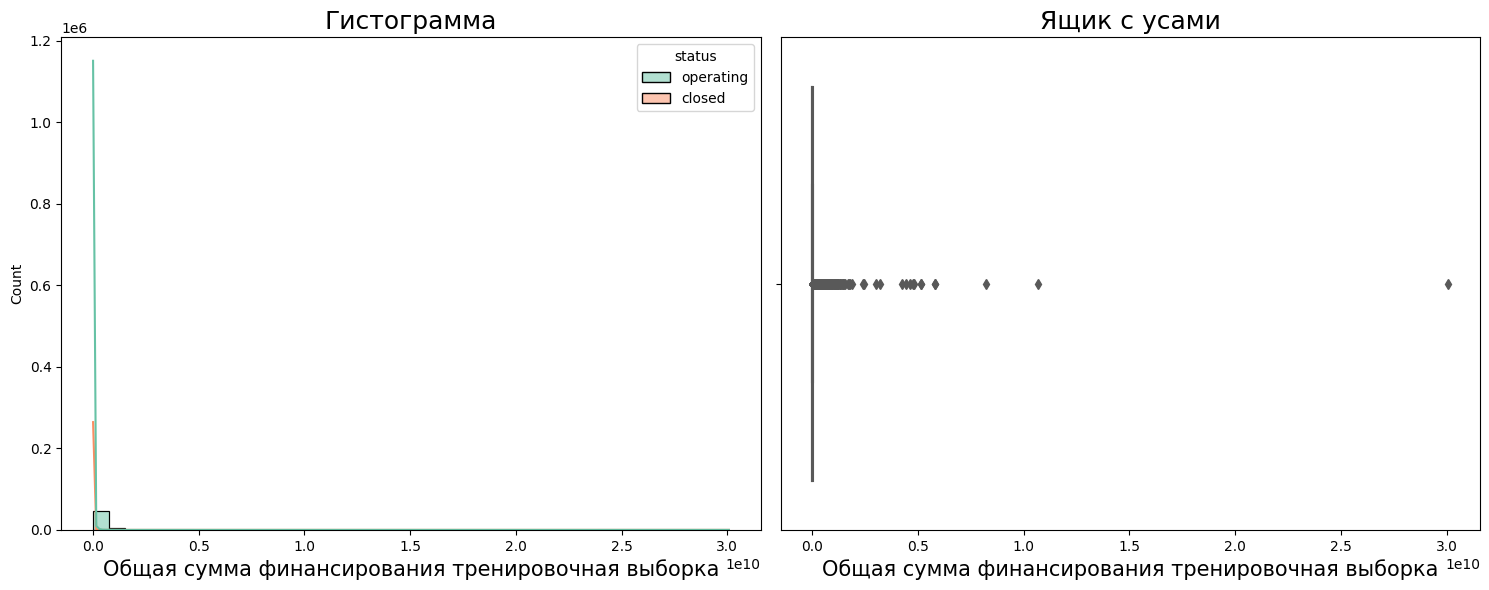

count           50,686.000
mean        15,281,342.313
std        171,367,330.412
min                  0.000
25%             63,400.250
50%          1,029,877.363
75%          7,286,731.500
max     30,079,503,000.000
Name: funding_total_usd, dtype: float64


In [31]:
quantitative_features(s_train, 'funding_total_usd', 'Общая сумма финансирования тренировочная выборка','status')

Наблюдается крупный разброс между 3 квартилем и максимальным значением. Посмотрим какие компании профинансированы более чем на 10 млр. долларов США.

In [32]:
s_train.query('funding_total_usd > 10000000000')

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
21241,Cambridge Technology Group,Consulting,"10,664,943,639.000",operating,NaN,NaN,NaN,NaN,1,1988-01-01,2000-01-01,2000-01-01,2018-01-01
39186,Verizon Communications,Communications Infrastructure,"30,079,503,000.000",operating,USA,NY,New York City,New York,5,1983-10-07,2010-01-26,2014-02-28,2018-01-01


Эти данные правдоподобны, сохраним значения. 

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` inste

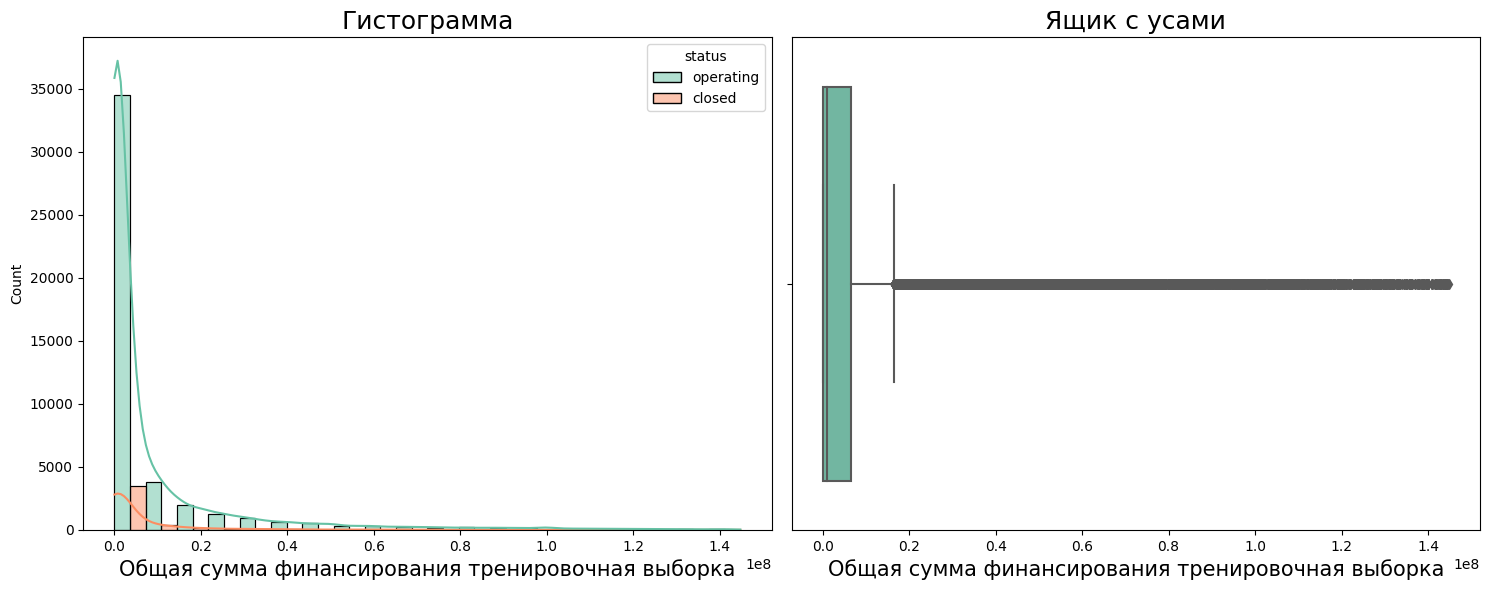

count        49,944.000
mean      8,448,240.600
std      18,958,139.873
min               0.000
25%          56,218.780
50%       1,000,000.000
75%       6,600,000.000
max     144,800,000.000
Name: funding_total_usd, dtype: float64


In [33]:
quantitative_features(s_train, 'funding_total_usd', 'Общая сумма финансирования тренировочная выборка','status', remove_outliers=True)

Гистограмма с длинным правым хвостом указывает на то что большинство значений сосредоточены в нижней части диапазона, но есть несколько значений, значительно превышающих среднее. Среднее значение в 5 раз выше медианного. Ящик с усами показывает большое количество выбросов.

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` inste

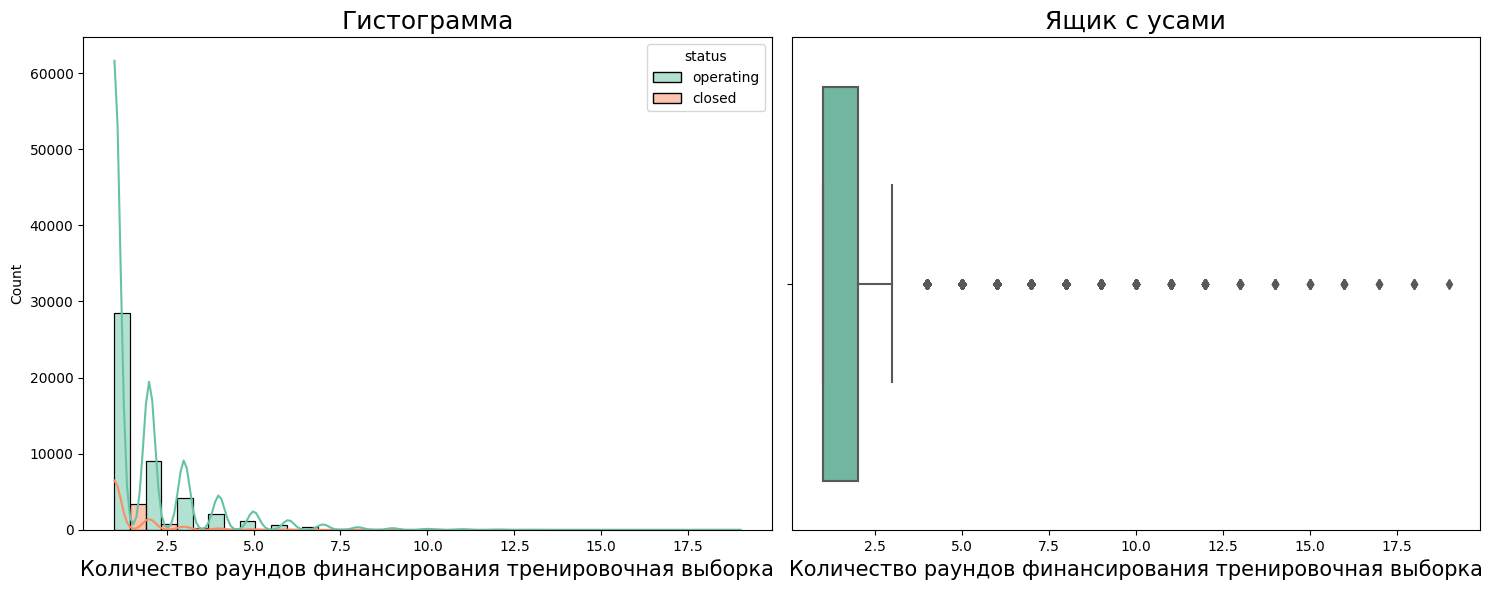

count   50,686.000
mean         1.764
std          1.392
min          1.000
25%          1.000
50%          1.000
75%          2.000
max         19.000
Name: funding_rounds, dtype: float64


In [34]:
quantitative_features(s_train, 'funding_rounds', 'Количество раундов финансирования тренировочная выборка','status')

Проверим какую компанию фиансировали 19 раз.

In [35]:
s_train.query('funding_rounds == 19 ')

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
52329,Solarflare Communications,Enterprise Software,"242,948,825.000",operating,USA,CA,Anaheim,Irvine,19,2005-01-01,2005-02-28,2015-01-05,2018-01-01


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` inste

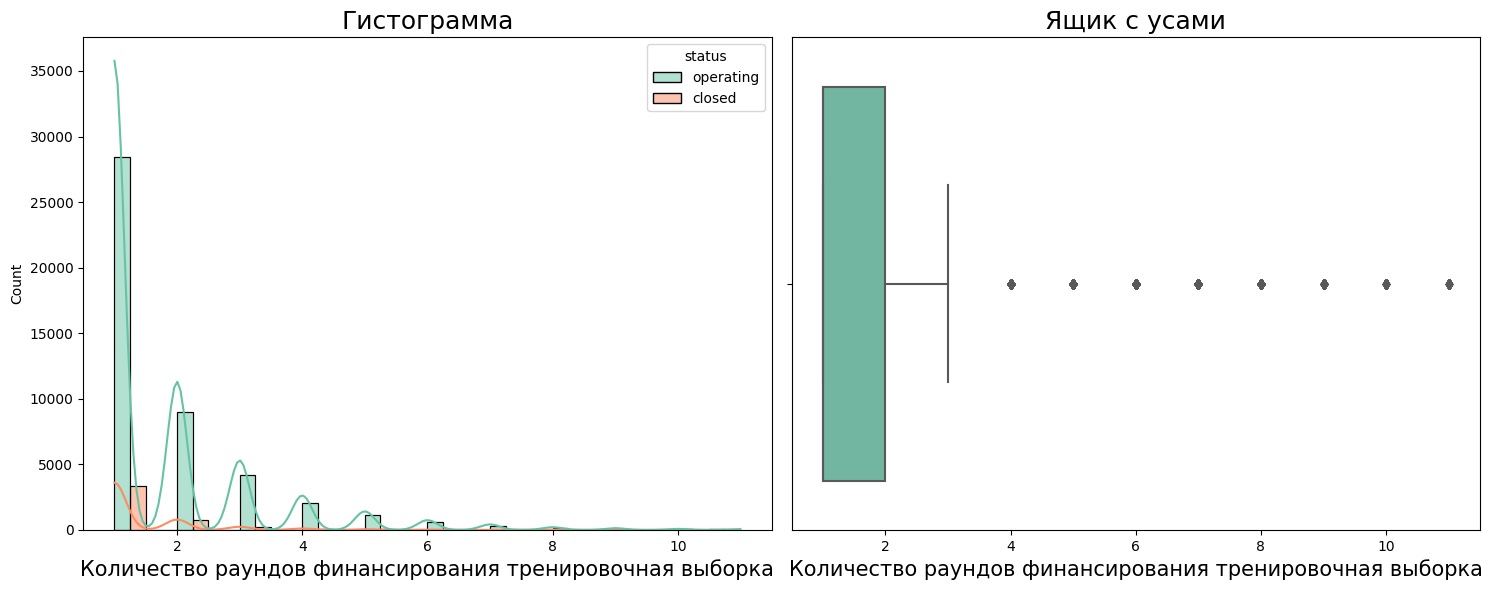

count   50,632.000
mean         1.751
std          1.334
min          1.000
25%          1.000
50%          1.000
75%          2.000
max         11.000
Name: funding_rounds, dtype: float64


In [36]:
quantitative_features(s_train, 'funding_rounds', 'Количество раундов финансирования тренировочная выборка','status', remove_outliers=True)

Вновь длинный правый хвост. Большинство стартапов финансируются за 1 раунд, в редких случаях более 2, но имеются случаи, когда финансирование требует более 5 раундов.

*Исследование количественных признаков тестовой выборки*

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


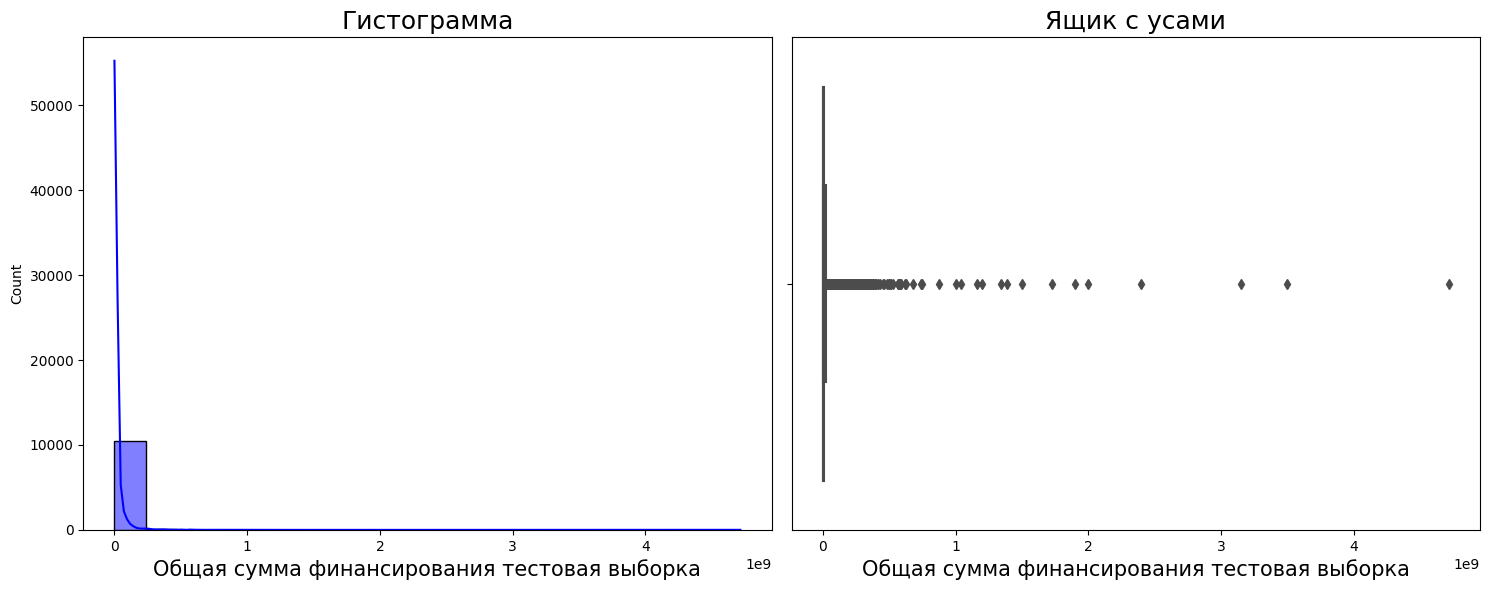

count          10,547.000
mean       16,549,102.695
std        92,172,825.632
min                 1.000
25%           320,000.000
50%         2,000,000.000
75%        10,000,000.000
max     4,715,000,000.000
Name: funding_total_usd, dtype: float64


In [37]:
quantitative_features(s_test, 'funding_total_usd', 'Общая сумма финансирования тестовая выборка')

invalid value encountered in greater_equal
invalid value encountered in less_equal
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


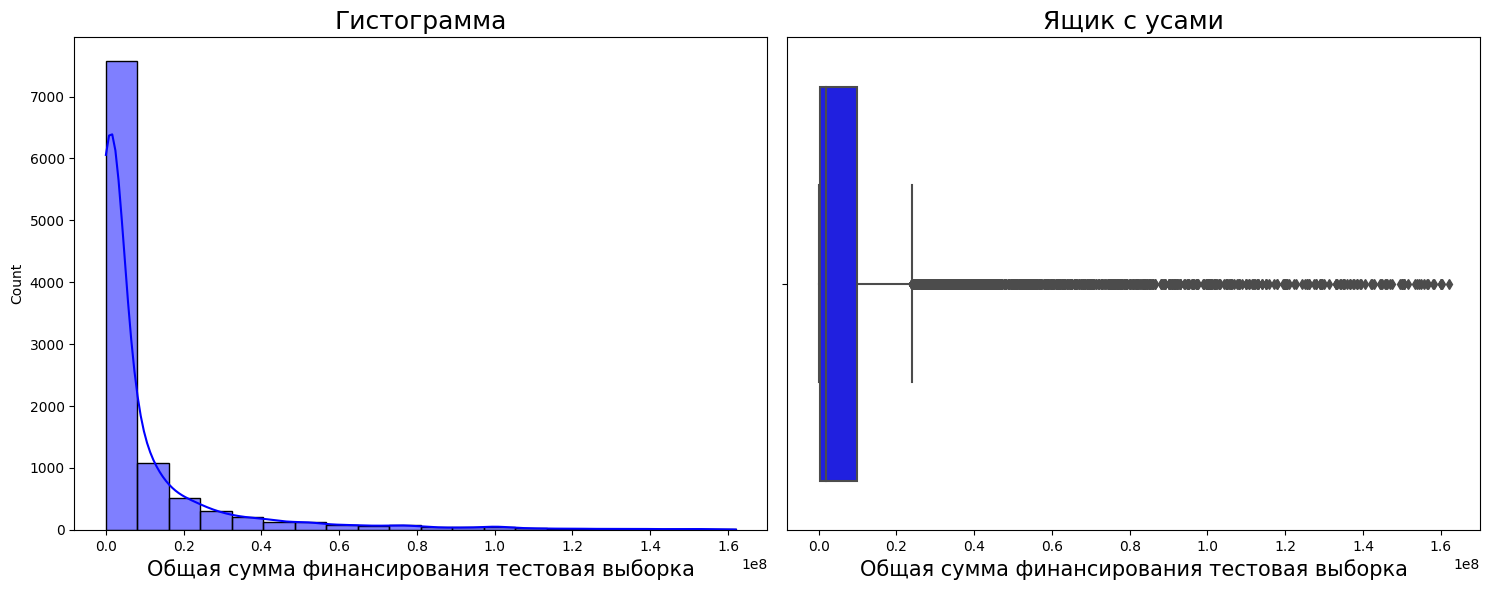

count        10,407.000
mean     10,270,778.488
std      21,228,902.188
min               1.000
25%         300,000.000
50%       1,900,000.000
75%       9,758,817.500
max     162,000,000.000
Name: funding_total_usd, dtype: float64


In [38]:
quantitative_features(s_test, 'funding_total_usd', 'Общая сумма финансирования тестовая выборка', remove_outliers=True)

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


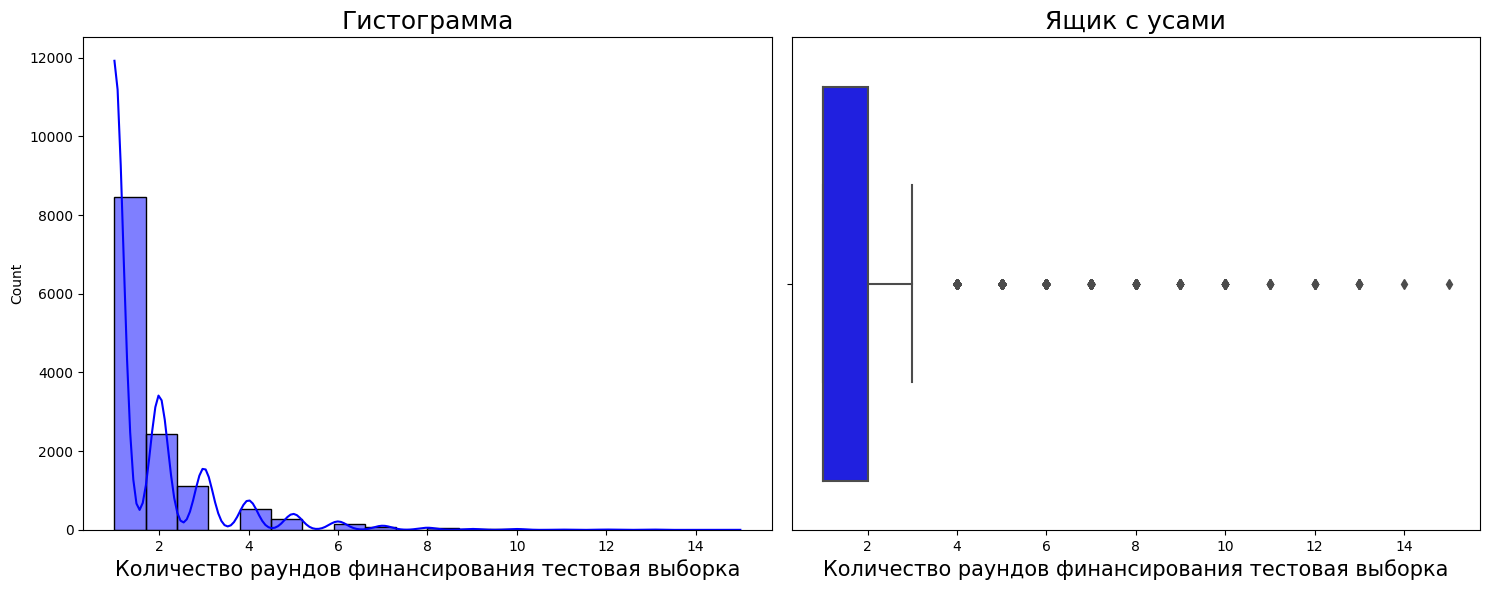

count   13,125.000
mean         1.714
std          1.319
min          1.000
25%          1.000
50%          1.000
75%          2.000
max         15.000
Name: funding_rounds, dtype: float64


In [39]:
quantitative_features(s_test, 'funding_rounds', 'Количество раундов финансирования тестовая выборка')

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


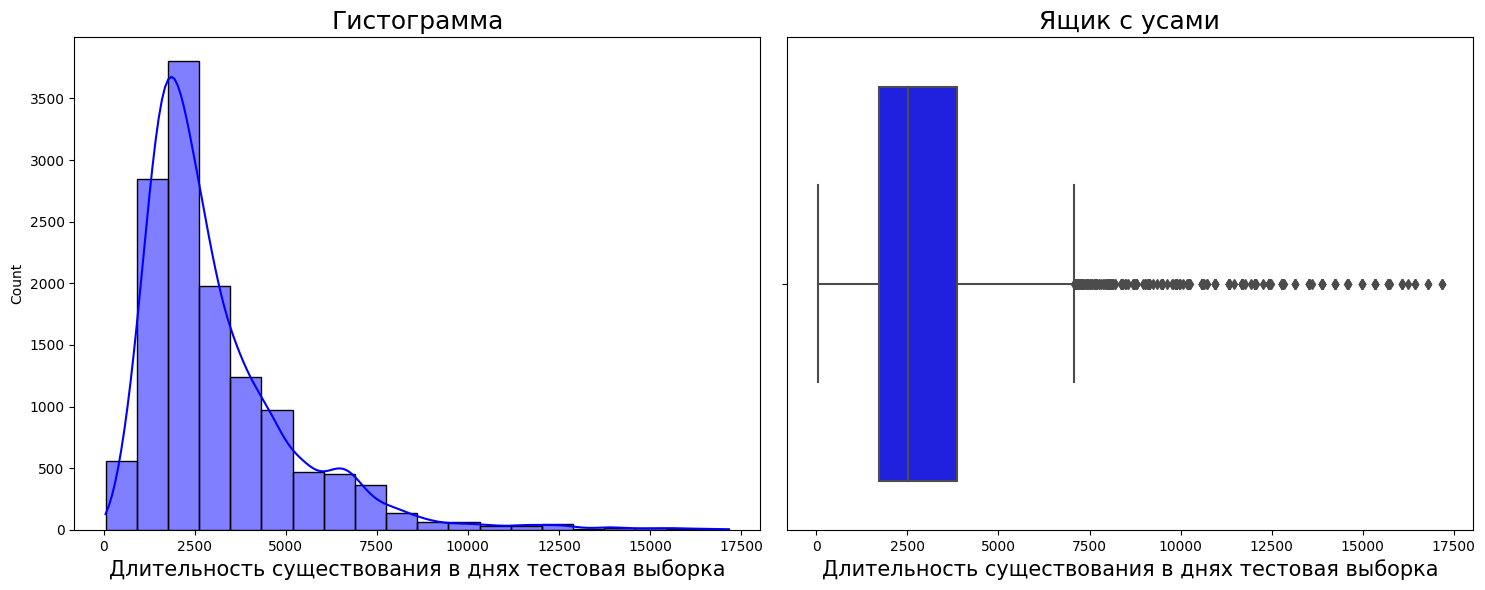

count   13,125.000
mean     3,097.610
std      2,128.357
min         52.000
25%      1,726.000
50%      2,526.000
75%      3,866.000
max     17,167.000
Name: lifetime, dtype: float64


In [40]:
quantitative_features(s_test, 'lifetime', 'Длительность существования в днях тестовая выборка')

Среднее от медианы отличается на 1000 дней, минимальная длительность существования 52 дня. В основном длительность существования от 1500 до 3000 дней.

### 3.3. Анализ датированных признаков 

In [41]:
def analyze_datetime_feature(df, date_column, hue=None, title=None):
    """
    Анализ и визуализация столбца с датами в датафрейме.
    
    Параметры:
    df: DataFrame - входной датасет
    date_column: str - название столбца с датами
    hue: str - название целевого признака для сегментации
    title: str - заголовок для графиков
    
    Возвращает:
    Графики
    """
    df_copy = df.copy()
    df_copy = df_copy.dropna(subset=[date_column])
    
    df_copy['year'] = df_copy[date_column].dt.year
    df_copy['year'] = df_copy['year'].astype('Int64')
    df_copy['month'] = df_copy[date_column].dt.month
    
    plt.figure(figsize=(12, 6))
    
    if hue and hue in df.columns:
        sns.histplot(df_copy, x='year', hue=hue, multiple="stack", bins=40, palette="Set2", kde=True)
        plt.legend(title=hue, labels=df_copy[hue].unique(), loc='upper right')
    else:
        sns.histplot(df_copy['year'], bins=30, kde=True, color='blue')
    
    plt.xlabel('Год')
    plt.ylabel('Количество')
    plt.title(title)
    plt.grid(True)
    plt.show()

    counts = df_copy.groupby(['year', 'month']).size().unstack().fillna(0)
    percentage = counts.div(counts.sum(axis=1), axis=0)

    percentage.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
    
    plt.xlabel('Год')
    plt.ylabel('Доля записей')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)
    plt.legend(title='Месяц', labels=['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 
                                      'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'])
    plt.tight_layout()
    plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` inste

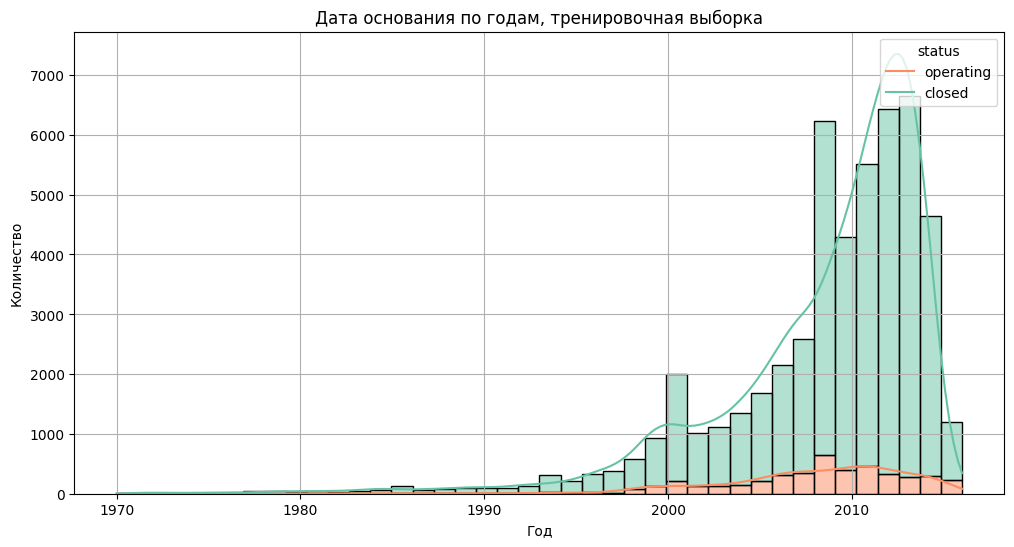

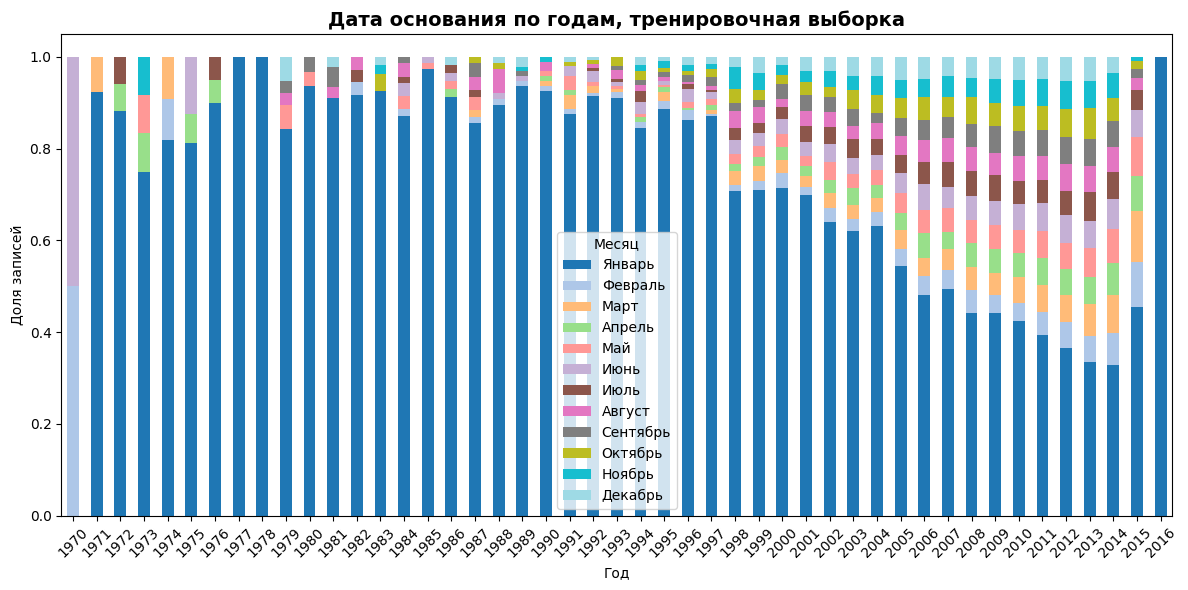

In [42]:
analyze_datetime_feature(s_train, 'founded_at', 'status', 'Дата основания по годам, тренировочная выборка')

С 1970 по 2016 год самым популярным месяцем для основания стартапов является январь, каждый год от 30% до 95%. Самыми вариативными на месяцы основания стартапа являются 2005-2015 годы. В 2016 год поделился на два месяца - январь и апрель. Наибольшее количество стартапов основано с 2008 по 2016 год, притом пиком является 2011, 2014 года.

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` inste

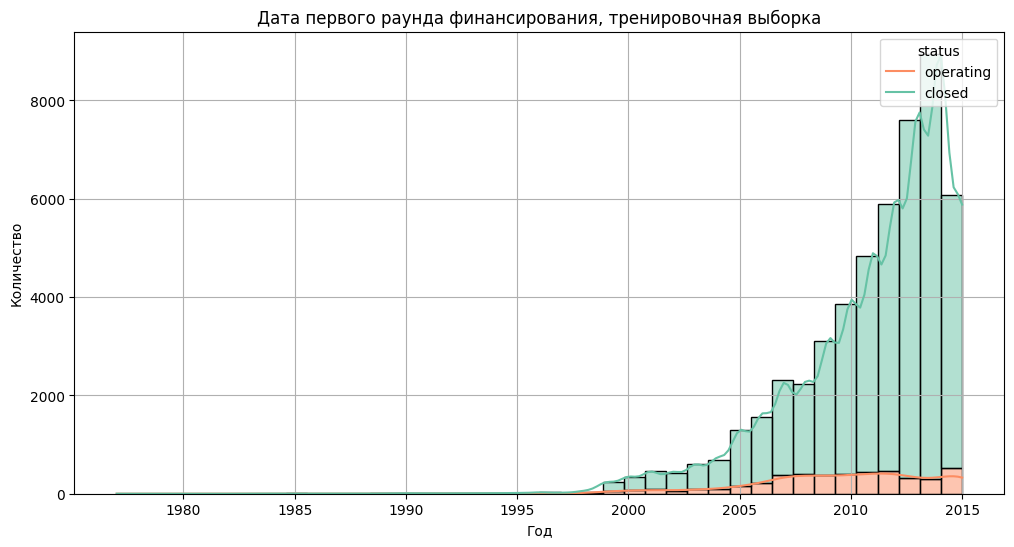

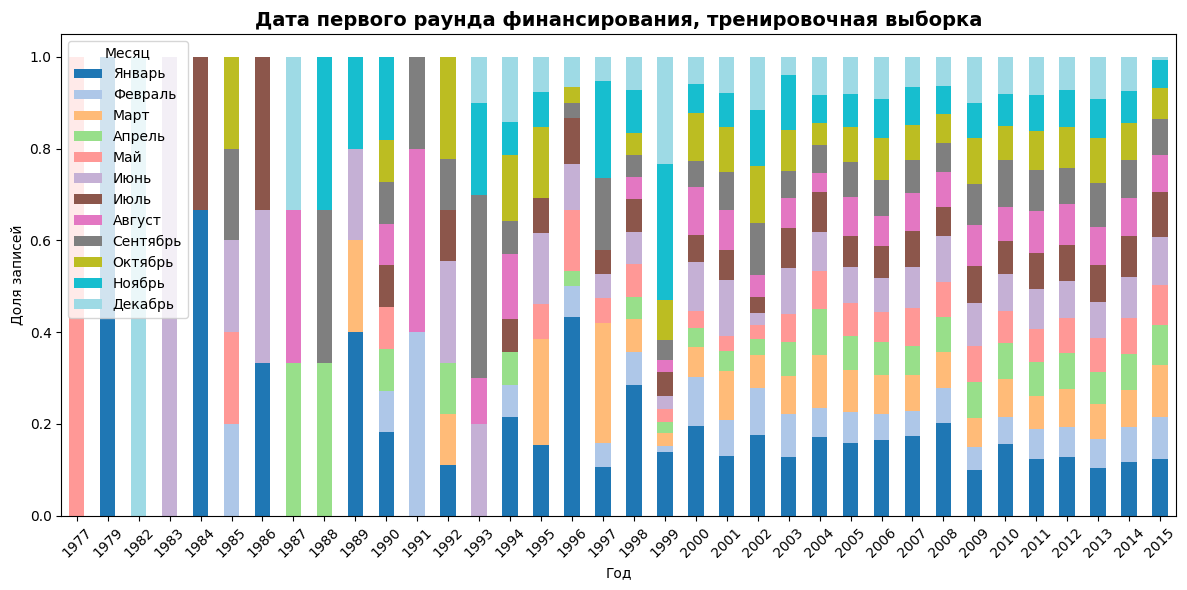

In [43]:
analyze_datetime_feature(s_train, 'first_funding_at', 'status', 'Дата первого раунда финансирования, тренировочная выборка')

Первые раунды финансирования имеют пик с 2010 по 2015 год. Реже всего первый раунд был весной, чаще всего зимой (с декабря по февраль).

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` inste

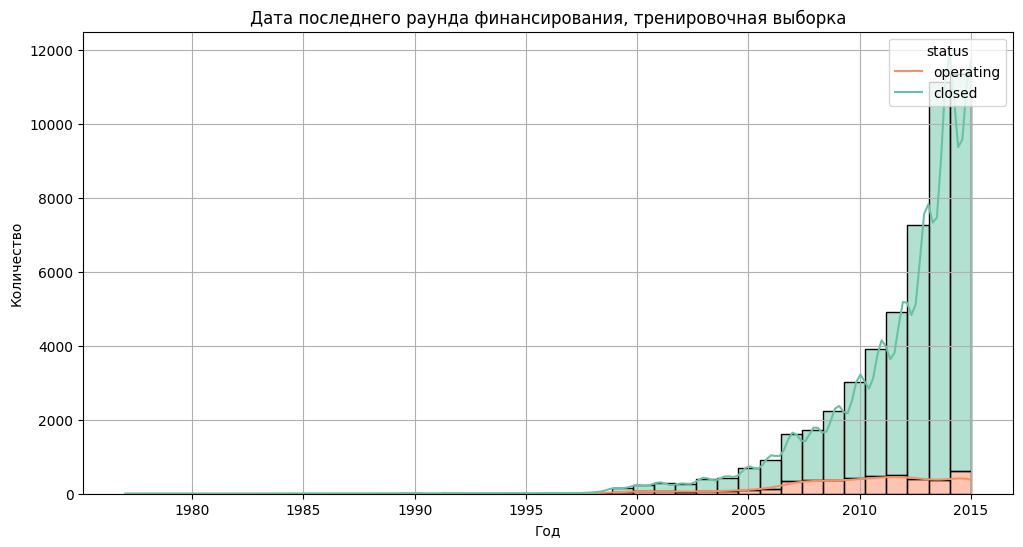

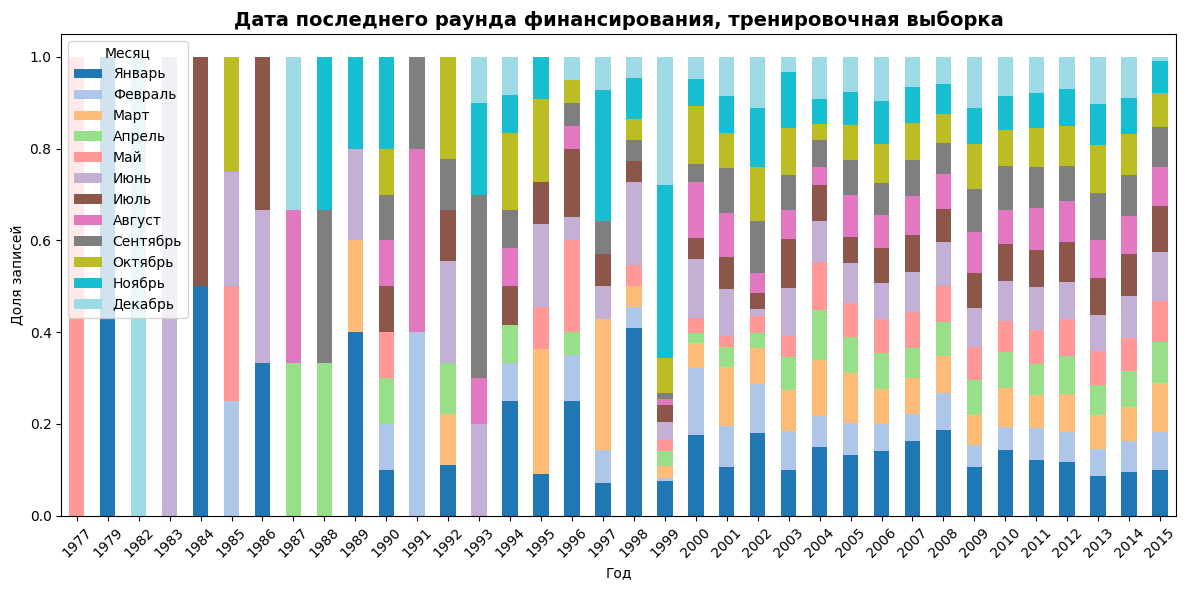

In [44]:
analyze_datetime_feature(s_train, 'last_funding_at', 'status', 'Дата последнего раунда финансирования, тренировочная выборка')

Последние раунды финансирования преимущественно происхоили зимой.

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` inste

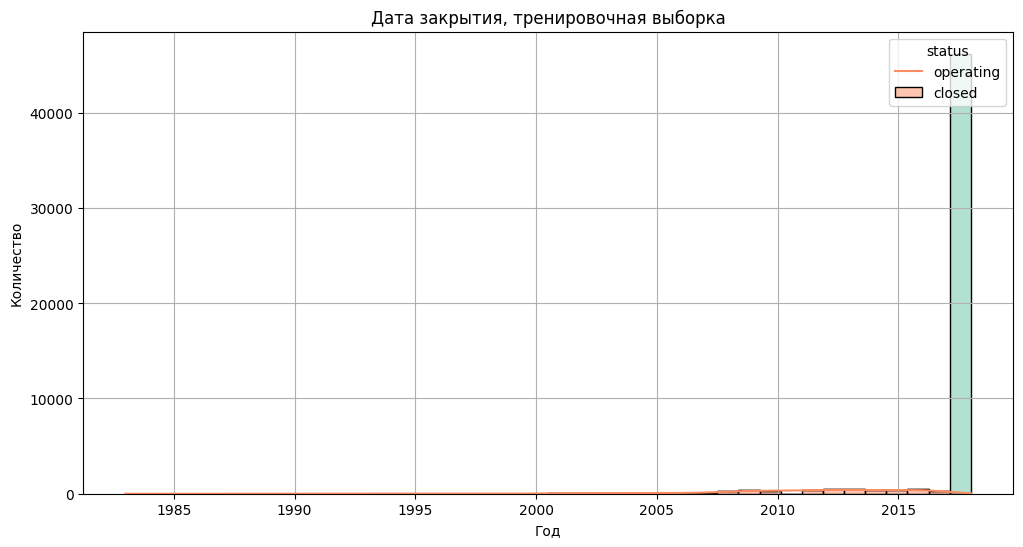

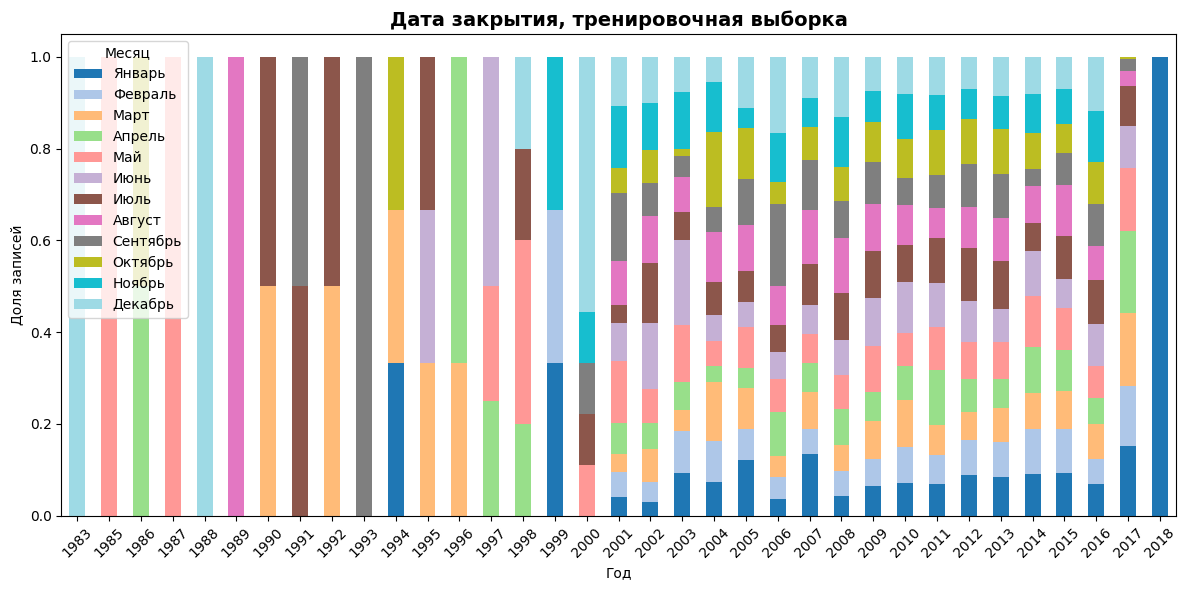

In [45]:
analyze_datetime_feature(s_train, 'closed_at', 'status', 'Дата закрытия, тренировочная выборка')

Реже всего компании закрывались весной, так же мало компаний было закрыто в 1999,2006 и 2011 годах.

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


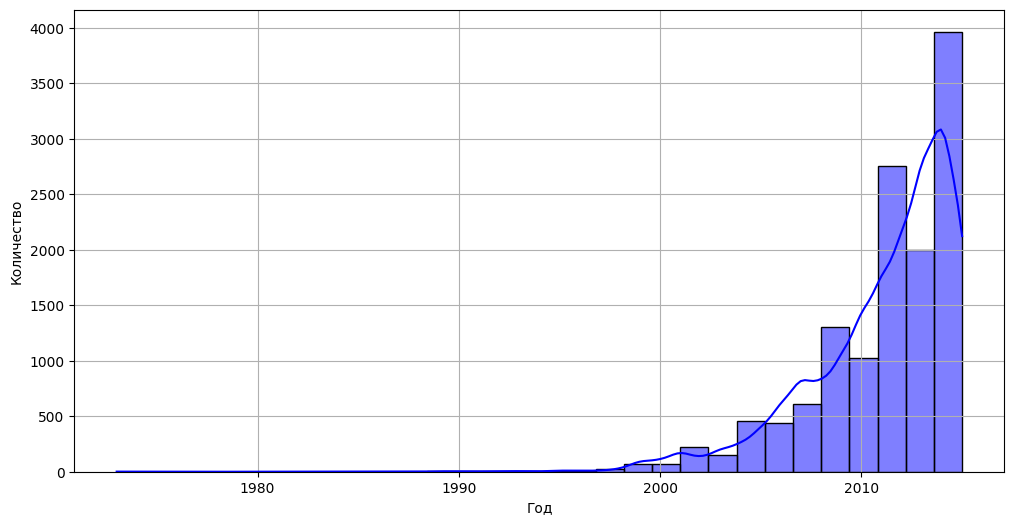

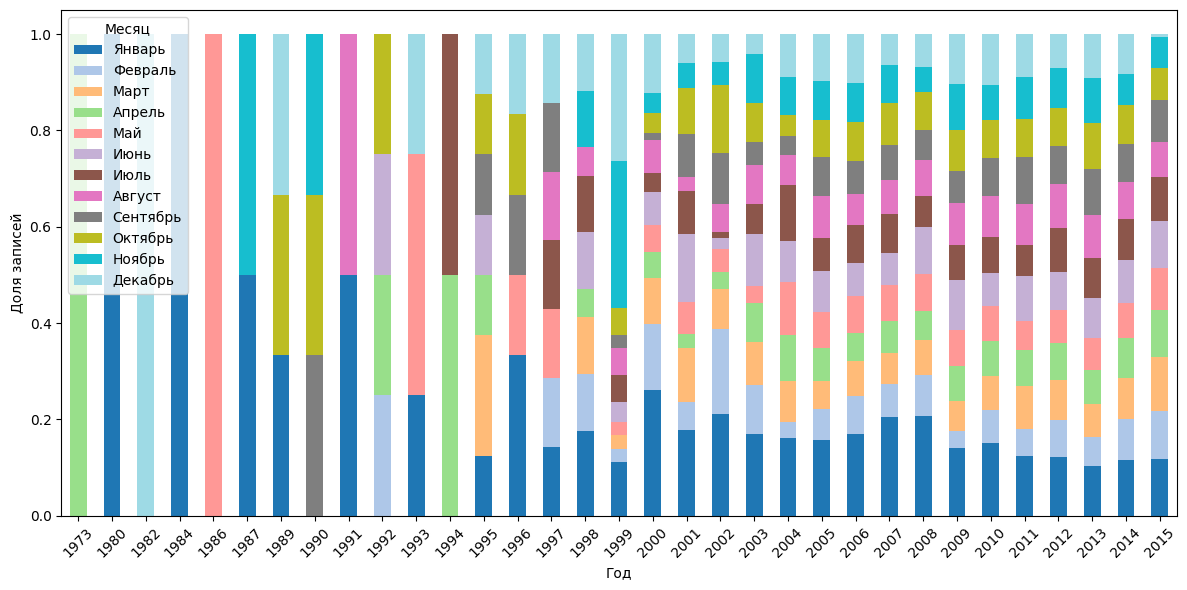

In [46]:
analyze_datetime_feature(s_test, 'first_funding_at', 'Дата первого раунда финансирования, тестовая выборка')

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


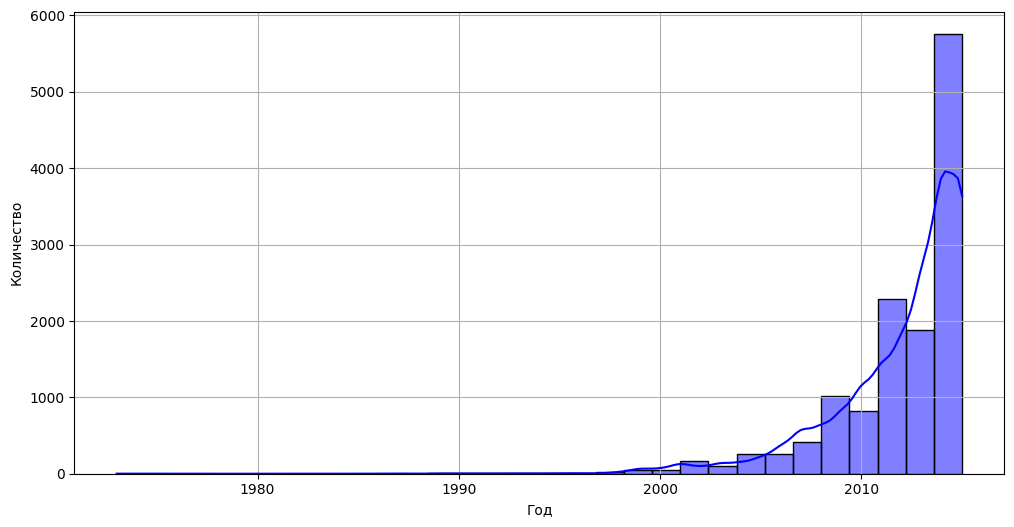

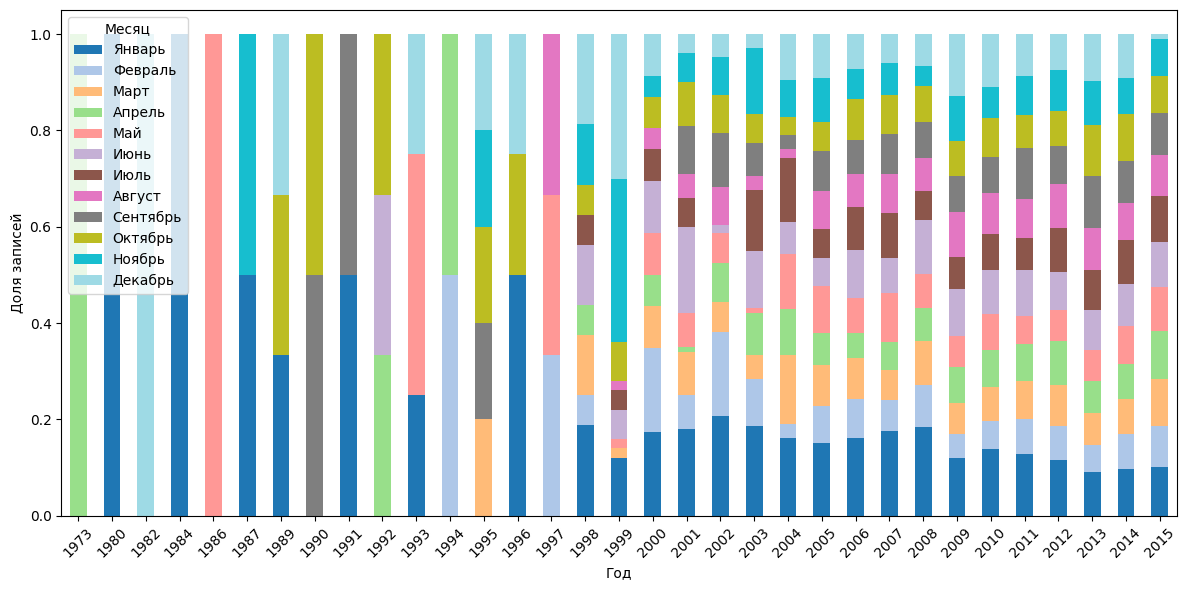

In [47]:
analyze_datetime_feature(s_test, 'last_funding_at', 'Дата последнего раунда финансирования, тренировочная выборка')

Тестовая выборка похожа на тренировочную, за одним исключением. Зимние месяцы в первом и последнем раундах финансирования лидируют в большей степени.

## Промежуточный вывод 

**Цель:** провести исследовательский анализ данных.  
**Задачи:**
1. Провести статистический анализ данных.

**Результаты**

1) Провести статистический анализ данных:
- При исследовании категориальных данных выявилось, что больше всего стартапов в сфере биотехнологий, програмного обеспечения и электронной коммерции, высокая доля стратапов из США, Великобритании и Канады, в США больше всего компаний в Калифорнии, Нью-Йорке, регионы Сан-Франциско, города - Сан-Франциско, Нью-Йорк, Бостон, Лондон. Наибольшее количество компаний закрыто в России.
- При исследовании количественных данных выявилось, что финансирование составляло от 300 тыс. до 10 млн. долларов, осуществлялось в 1-2 раунда, закрытые компании существовали от 1500 до 3000 дней.
- Наибольшее количество компаний были открыты с 2010 по 2016 год, первый раунд финансирование, открытие и закрытие компаний приходятся на зимние месяцы. 
- Распределения тестовой выборки похожи на тренировочную.
- Целевой признак имеет дисбаланс классов. 

# Шаг 4. Разработка новых синтетических признаков

Приведем к единому виду тренировочную и тестовую выборки. Для этого:   
* из тренировочной выборки - удалим столбцы `closed_at`, `founded_at`, создадим `lifetime`, создадим `funding_duration` с количеством дней между первым и последним днем финансирования, `avg_funding_round_size` со средним финансовым размемром раунда.

In [48]:
df_train = s_train.copy()
df_train['lifetime'] = (df_train['closed_at'] - df_train['founded_at']).dt.days
df_train['funding_duration'] = (df_train['last_funding_at'] - df_train['first_funding_at']).dt.days
df_train['avg_funding_round_size'] = df_train['funding_total_usd'] / df_train['funding_rounds']

bins = [-1, 0, 55000, 1000000, 6500000, float('inf')]
labels = ["нет финансирования", "малоe финансирования", "умеренное финансирование", "среднее финансирование", "высокое финансирование"]
df_train['finance'] = pd.cut(df_train['funding_total_usd'], bins=bins, labels=labels)


df_test = s_test.copy()
df_test['funding_duration'] = (df_test['last_funding_at'] - df_test['first_funding_at']).dt.days
df_test['avg_funding_round_size'] = df_test['funding_total_usd'] / df_test['funding_rounds']
df_test['finance'] = pd.cut(df_test['funding_total_usd'], bins=bins, labels=labels)

In [49]:
df_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,funding_duration,avg_funding_round_size,finance
0,Lunchgate,Online Reservations,"828,626.000",operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01,2998,1310,"414,313.000",умеренное финансирование
1,EarLens,Manufacturing,"42,935,019.000",operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,4748,1393,"10,733,754.750",высокое финансирование
2,Reviva Pharmaceuticals,Biotechnology,"35,456,381.000",operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,4383,681,"11,818,793.667",высокое финансирование
3,Sancilio and Company,Health Care,"22,250,000.000",operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,5114,1051,"7,416,666.667",высокое финансирование
4,WireTough Cylinders,Manufacturing,0.000,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2018-01-01,2791,0,0.000,нет финансирования


In [50]:
df_train = df_train.drop(['name','founded_at','closed_at','last_funding_at','first_funding_at','funding_total_usd'], axis=1)
df_test = df_test.drop(['last_funding_at','first_funding_at','funding_total_usd'], axis=1)

In [51]:
print(df_train.info(), df_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 50686 entries, 0 to 52515
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   category_list           50686 non-null  object  
 1   status                  50686 non-null  object  
 2   country_code            47010 non-null  object  
 3   state_code              45749 non-null  object  
 4   region                  46153 non-null  object  
 5   city                    46153 non-null  object  
 6   funding_rounds          50686 non-null  int64   
 7   lifetime                50686 non-null  int64   
 8   funding_duration        50686 non-null  int64   
 9   avg_funding_round_size  50686 non-null  float64 
 10  finance                 50686 non-null  category
dtypes: category(1), float64(1), int64(3), object(6)
memory usage: 4.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Colum

## Промежуточный вывод

**Цель:** создать новые синтетические признаки.
1. Созданы столбцы в обоих выборках `funding_duration` с длительностью финансирования, `avg_funding_round_siz` с средним финансированием за раунд.
2. Cсозданы датафреймы `df_train`, `df_test` на основe `s_train`, `s_test` с новыми столбцами из которых удалены столбцы `name`, `last_funding_at`, `first_funding_at`, `closed_at`, `founded_at`.

 # Шаг 5. Проверка на мультиколлинеарность.

The number of unique values of variable city is large: 4477. Are you sure this is not an interval variable? Analysis for pairs of variables including city can be slow.
The number of unique values of variable region is large: 1036. Are you sure this is not an interval variable? Analysis for pairs of variables including region can be slow.


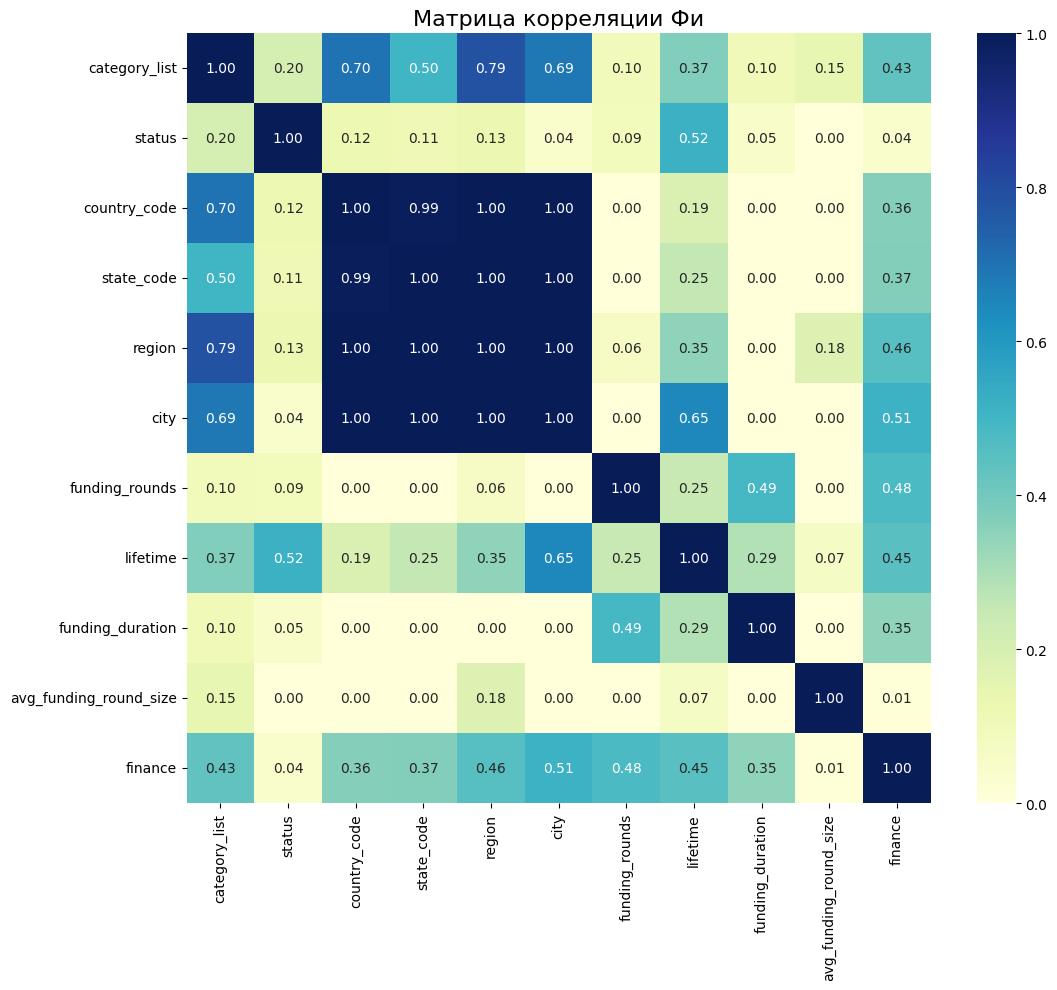

In [52]:
interval_cols = df_train.select_dtypes(include=['number']).columns.tolist()

phik_overview = df_train.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(12, 10)) 
sns.heatmap(phik_overview, annot=True, fmt='.2f', cmap='YlGnBu', vmin=0, vmax=1)
plt.title('Матрица корреляции Фи', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Столбцы с указанием географических данных сильно коррелируют друг с другом, удали все кроме `country_code`, так как в этом столбце меньше всего пропуском и некорректных данных, так же слабая корреляция с целевым признаком.

In [53]:
df_train = df_train.drop(['state_code', 'region', 'city'], axis=1)
df_test = df_test.drop(['state_code', 'region', 'city'], axis=1)

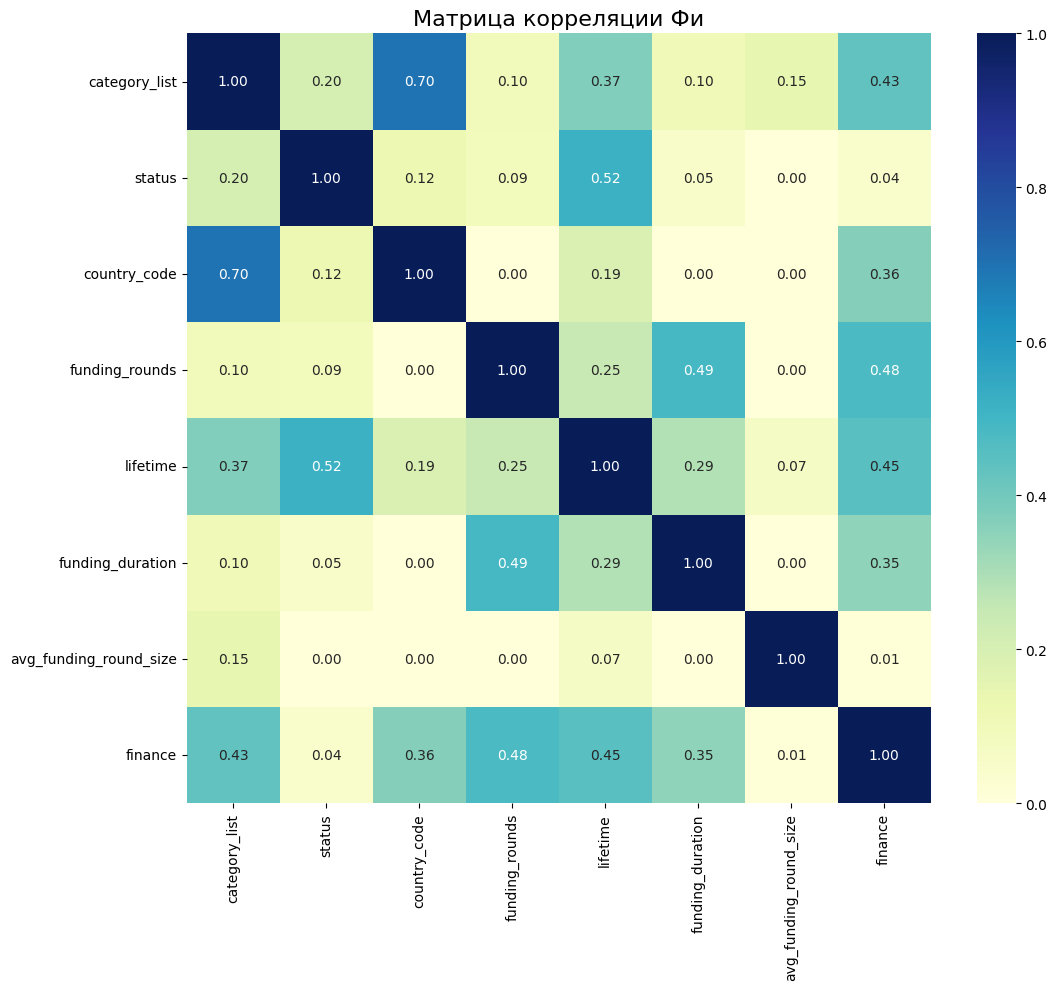

In [54]:
interval_cols = df_train.select_dtypes(include=['number']).columns.tolist()
phik_overview = df_train.phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(12, 10)) 
sns.heatmap(phik_overview, annot=True, fmt='.2f', cmap='YlGnBu', vmin=0, vmax=1)
plt.title('Матрица корреляции Фи', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

У целевого признака `status` средняя корреляция с признаком `lifetime`, умеренная корреляция с `category_list`. 

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping wi

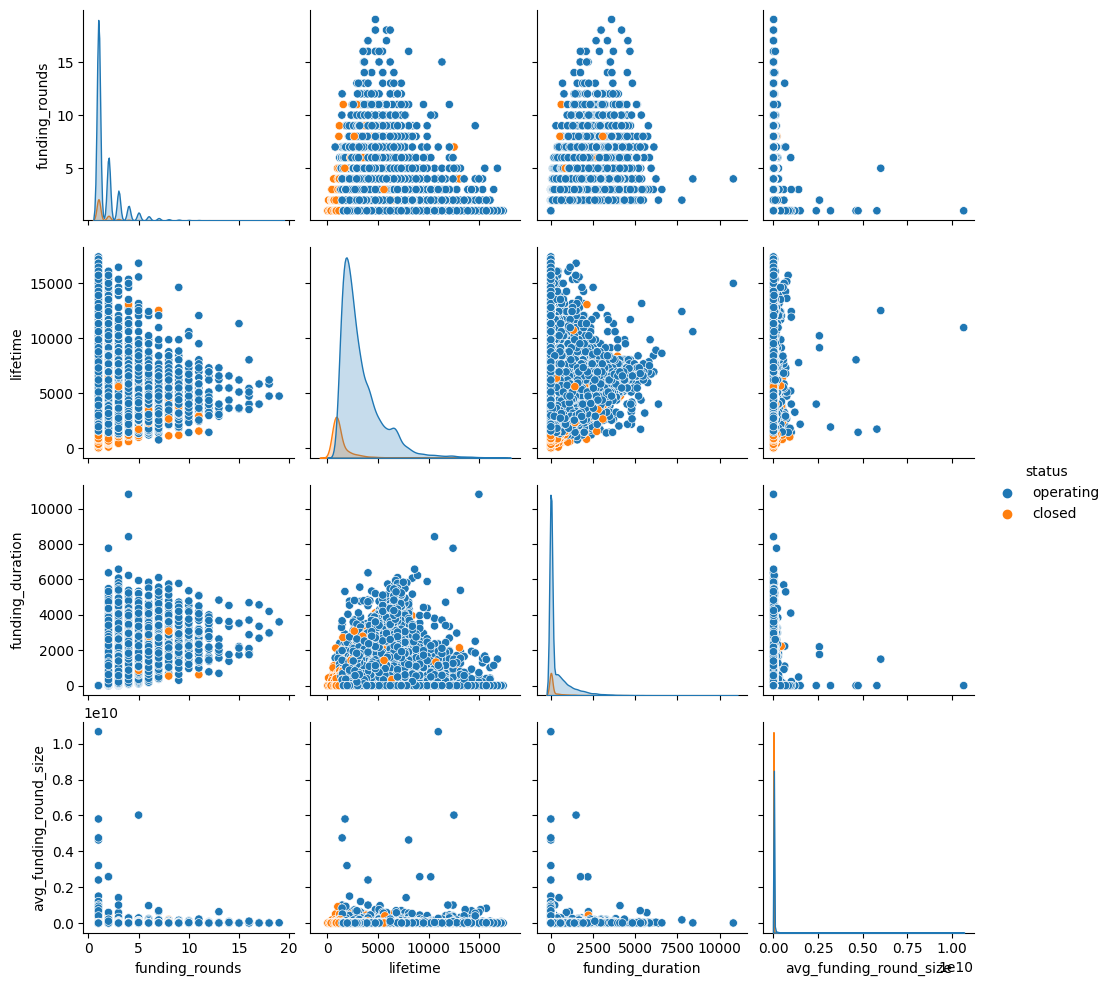

In [55]:
sns.pairplot(df_train, hue="status")
plt.show()

Компании с большим количеством раундов финансирования и высокой общей суммой инвестиций с большей вероятностью остаются открытыми. 

## Промежуточный вывод

**Цель:** провести анализ коллинеарности признаков.
1. Выялена мультиколлинеарность `country_code`, `state_code`, `region`, `city`, удалено все, кроме `country_code`.
2. Целевой признак имеет среднюю зависимость с признаком `lifetime` и умеренную зависимость с `category_list`.


    
<div class="alert alert-success">
<b>отлично ✅:</b> </div>
    


# Шаг 6.  Выбор и обучение моделей.

Первым делом создадим списки для кодирования и масштабирования данных. Целевой признак нужно закодировать при помощи LabelEncoder.
Для категориальных признаков будем использовать OrdinalEncoder, для количественных MinMaxScaler и StandartScaler. Так же нам нужно заполнить пропуски SimpleImputer.

In [56]:
ord_columns = [
    'category_list',
    'country_code',
    'finance'
]
num_columns = [ 
    'funding_rounds',
    'funding_duration',
    'lifetime',
    'avg_funding_round_size'
]

Оформим выборки.

In [57]:
X_train = df_train.drop('status', axis=1)
y_train = df_train['status']

print(X_train.shape)
print(y_train.shape)

(50686, 7)
(50686,)


In [58]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)

Проверим как закодирован целевой признак.

In [59]:
original_labels = encoder.inverse_transform([0, 1])

print(f"Значение для 0: {original_labels[0]}")
print(f"Значение для 1: {original_labels[1]}")

Значение для 0: closed
Значение для 1: operating


In [60]:
ord_pipe = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])
num_pipe = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', MinMaxScaler())
])
data_preprocessor = ColumnTransformer(
    [('cat', ord_pipe, ord_columns),
     ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

Так как целевой признак категориальный, то попробуем модели: KNN, логистическая регрессия, дерево решений. Оптимизируем гиперпараметры при помощи GridSearchCV. Используем f1 macro для того чтобы получить корректную оценку метрики при условиях несбаланисированного целевого признака. Целевой признак не будет сбалансирован, так как нужно обучить модель работать с реальными (несбалансированными) данными.

In [61]:
%%time
param_grid = [
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': range(2, 15),
        'classifier__metric' : ['euclidean','manhattan'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'classifier': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'classifier__max_depth': range(2, 10),
        'classifier__min_samples_split': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'classifier': [GradientBoostingClassifier(random_state=RANDOM_STATE)],
        'classifier__n_estimators': [100,200],
        'classifier__learning_rate': [0.1],
        'classifier__max_depth': [3, 5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
] 


f1 = make_scorer(f1_score , average='macro')

pipe_final = ImbPipeline([
    ('preprocessor', data_preprocessor),
    ('classifier', LogisticRegression(solver='saga', max_iter=500)) 
])

grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5,
    scoring=f1,
    n_jobs=-1 
)

grid.fit(X_train, y_train)

print("Лучшие параметры:", grid.best_params_)
print("Лучший F1-Score:", grid.best_score_)

Лучшие параметры: {'classifier': GradientBoostingClassifier(max_depth=5, n_estimators=200, random_state=42), 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'preprocessor__num': StandardScaler()}
Лучший F1-Score: 0.8442187501381143
CPU times: user 37.4 s, sys: 1.45 s, total: 38.8 s
Wall time: 5min 5s


Приведем тестовую выборку в норму.

In [62]:
df_test['category_list'] = df_test['category_list'].fillna('Unknown')
df_test['country_code'] = df_test['country_code'].fillna('Unknown')
df_test['avg_funding_round_size'] = df_test['avg_funding_round_size'].fillna('0')
df_test['finance'] = df_test['finance'].fillna('нет финансирования')

df_test['status'] = grid.best_estimator_.predict(df_test.drop('name', axis=1))

In [63]:
finish = df_test[['name','status']]
finish.head(5)

,name,status
0,Crystalsol,1
1,JBI Fish & Wings,1
2,COINPLUS,1
3,Imagine Communications,1
4,DNA13,1


Раскодируем целевые признаки.

In [64]:
finish.loc[:, 'status']= encoder.inverse_transform(finish['status'])
finish.head(5)

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['operating' 'operating' 'operating' ... 'operating' 'operating'
 'operating']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.


,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating


In [65]:
finish['status'].value_counts()

status
operating    12178
closed         947
Name: count, dtype: int64

In [66]:
finish.to_csv('/kaggle/working/12178.csv', index=False)

## Промежуточный вывод

**Цель:** Выбор и обучение моделей, итоговая оценка качества предсказания лучшей модели.
1. Категориалиные признаки закодированы OrdinalEncoder, количественные масштабированы MinMaxScaler и StandartScaler.
2. Целевой признак закодирован LabelEncoder.
3. Подготовлен пайплайн `data_preprocessor` для подготовки данных к обучению.
4. Протестированы модели 3 модели, оптимизированных с помощью GridSearchCV.
5. Лучшая модель: дерево решений с максимальной глубиной 5, минимальным количеством образцов для разделения 2, значение ключевой метрики f1 = 0.77
6. Лучший порог классификации равен 0.103 при котором AUC = 0.99.


<div class="alert alert-warning">
<b>а вот выбор моделей не самый удачный. на логистическую регрессию можно было бы время и не тратить ⚡:</b> </div>


# Шаг 7. Итоговая оценка качества предсказания лучшей модели.

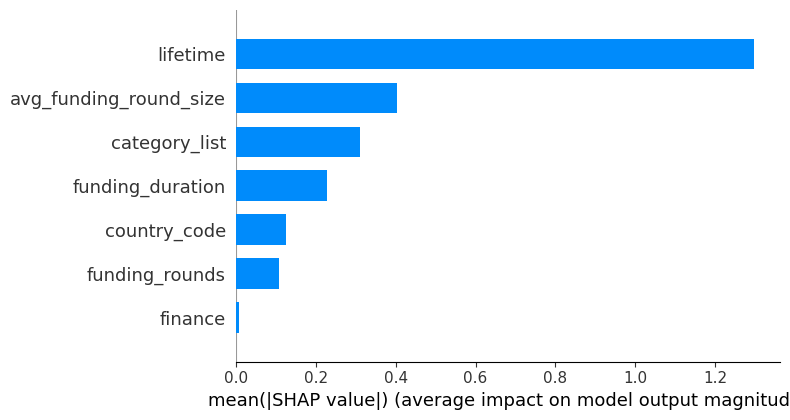

In [67]:
best_model = grid.best_estimator_
tree_model = best_model.named_steps['classifier']  

X_test_preprocessed = best_model.named_steps['preprocessor'].transform(df_test.drop('name', axis=1))

ord_feature_names = ord_columns
num_feature_names = num_columns

all_feature_names = np.concatenate([ord_feature_names, num_feature_names])

X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=all_feature_names)

explainer = shap.TreeExplainer(tree_model)
shap_values = explainer.shap_values(X_test_preprocessed_df)

shap.summary_plot(shap_values, features=X_test_preprocessed_df, feature_names=all_feature_names, plot_type="bar")

Самый важный признак для предсказания модели - время жизни стартапа, причем поровну влияет на оба класса.Длительность финансирования и общая сумма финансирования влияет намного меньше, но так же поровну. Остальные признаки оказывают слабое влияние.

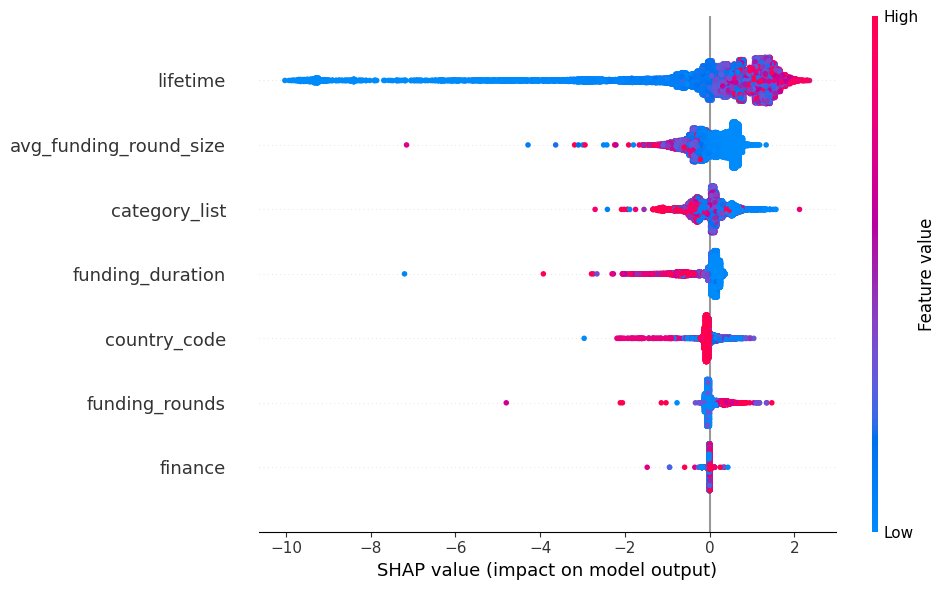

In [68]:
shap_values = explainer.shap_values(X_test_preprocessed_df.values)
shap_values_class_1 = shap_values[1] if isinstance(shap_values, list) else shap_values

shap.summary_plot(shap_values_class_1, 
                  X_test_preprocessed_df, 
                  feature_names=all_feature_names, 
                  plot_size=(10, 6))

Преимущественно синие(низкие показатели) длительности жизни стартапа указывают на то, что модель с большой вероятностью присвоит 1 класс (closed). О закрытии так же свидетельсвуют высокие показатели среднего объема финансирования за раунд, долгое время финансирования.

## Промежуточный вывод

**Цель:** Анализ важности признаков.
1. Основной фактор, влияющий на предсказания модели, — это время жизни стартапа `lifetime`.
2. Cтартапы с коротким временем жизни имеют более высокую вероятность быть закрытыми.
3. Признаки, связанные с финансированием оказывают меньшее влияние, но долгое время и высокий объем финансирования за раунд свидетельсвуют о скором закрытии.
4. Остальные признаки оказывают слабое влияние на предсказание модели.

# Общий вывод.

**Цель проекта:**  
Целью данного проекта было разработать модель для предсказания успешности стартапа, то есть определить, закроется ли стартап или продолжит свою деятельность.

1. Загрузка и предобработка данных:
На первом этапе работы с данными была проведена загрузка и предварительное знакомство с датасетами. Объем данных составил 13125 строк для тестового набора и 52516 строк для тренировочного. В процессе проверки было обнаружено несколько проблем, таких как наличие пропусков и некорректных типов данных. Были выполнены следующие этапы предобработки:

- Исправлены типы данных, в частности для столбцов с датами.

- Обработаны пропуски, включая удаление строк с неизвестными значениями в столбце country_code.

2. Статистический анализ данных:
На основе статистического анализа данных были выявлены интересные закономерности:

- Стартапы, работающие в сферах биотехнологий, программного обеспечения и электронной коммерции, занимают наибольшую долю.

- Основные страны-участники — США, Великобритания и Канада, с наибольшим количеством стартапов в таких городах, как Сан-Франциско, Нью-Йорк и Лондон.

- Финансирование стартапов варьировалось от 300 тыс. до 10 млн долларов, при этом наибольшее количество стартапов было открыто в период с 2010 по 2016 год, а первый раунд финансирования чаще всего приходился на зимние месяцы.

3. Создание синтетических признаков:
Для улучшения качества модели были созданы новые синтетические признаки:

- funding_duration — продолжительность финансирования.

- finance - переведенная в категориальный признак сумма финансирования.

- avg_funding_round_size — средняя сумма финансирования за раунд. Эти признаки были добавлены в тренировочную и тестовую выборки, после чего были удалены ненужные столбцы, такие как name, last_funding_at, first_funding_at, closed_at, founded_at.

4. Анализ мультиколлинеарности:
Проведенный анализ коллинеарности показал, что признаки country_code, state_code, region и city сильно коррелируют между собой. В связи с этим было решено оставить только country_code, который в дальнейшем использовался для построения модели.

5. Обучение моделей:
В качестве обучающих моделей были протестированы три алгоритма, и с помощью метода GridSearchCV был выбран лучший гиперпараметр для каждого из них. Лучшей моделью оказалось GradientBoostingClassifier с максимальной глубиной 5 и минимальным количеством образцов для разделения равным 2. Оценка качества модели показала, что наилучший результат по метрике F1 составил 0.84.

6. Анализ важности признаков:
Основной вывод из анализа важности признаков заключается в следующем:

- lifetime (время жизни стартапа) оказалось самым важным признаком для предсказания успешности стартапа.
- Чем больше и дольше финансируют стартап, тем выше вероятность его закрытия.
- Признаки, связанные с финансированием (например, funding_duration и funding_total_usd), оказывают менее значительное влияние.


**Заключение:** 
Проект продемонстрировал, что время жизни стартапа является основным фактором, влияющим на вероятность его закрытия, что подтверждается сильным влиянием этого признака на предсказания модели. Признаки, связанные с финансированием, также играют важную роль, но их влияние менее выражено. Разработанная модель, используя GradientBoostingClassifier, имеет хорошее качество предсказания с высоким значением F1. Скорее всего, если стартап часто финансируют, тем больше это говорит, что он сам не может себя содержать, следовательно он мало приносит прибыли, поэтому организация может закрыться. Это исследование подтверждает значимость факторов времени жизни стартапа и финансирования в определении успешности стартапов. В дальнейшем можно исследовать дополнительные факторы или улучшить модель, добавив новые признаки для повышения точности предсказаний.


    
<div class="alert alert-success">
<b>Вывод ревьюера ✅:</b> 

Отличный анализ данных и шикарные визуализации. немного подкачал выбор моделей, а в остальном - классная работа
    
    
удачи!


</div>
